In [1]:
import pathlib

import yaml

import numpy as np

import itertools

In [2]:
from pixell import enmap, utils as putils

In [3]:
import utilities as u

In [4]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [5]:
import best
import re

In [6]:
paperplots = pathlib.Path('paperplots')

### Some general settings

In [360]:
values_file = 'config.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [361]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [362]:
C = u.Converting()

In [363]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [364]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [365]:
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

In [366]:
PP

PosixPath('output')

## Plot noises for lmax = 3500 vs signal

In [376]:
lmax_fixed = 3500

In [377]:
fsky = 1.

In [378]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft)

In [379]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['A1', 'A2']
feed_dict = u.Loadfeed_dict(spectra_path, field_names_A, field_names_A, modlmap)

/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:353: RuntimeWarning: divide by zero encountered in log
  logTT = np.log(ctt)


In [17]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 20, 6000

In [18]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [19]:
lmaxes = lmaxes_configs[0] 
lmaxes_dict = {}
lmax_directory = ''

noise_dict = {}

for e_index, e in enumerate(estimators):
    l = lmax_fixed #lmaxes[e_index]
    lmaxes_dict[e] = l
    lmax_directory += f'{names[e]}{l}'
    hardening = estimators_dictionary[e]['hardening']
    A = u.Estimator(shape, wcs, feed_dict, e, lmin_A, lmax_A,
            field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
            hardening = hardening, XY = 'TT')
    NAB_cross = A.get_Nl_cross(A)
    el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    noise_dict[e] = NAB_cross_binned

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul


In [20]:
P = PP/lmax_directory

getoutname = lambda key: f'{key}_{nu}.npy'

noises = np.load(P/getoutname(noisetag))
ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

In [21]:
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 15)

findfont: Font family ['Latin Modern Roan'] not found. Falling back to DejaVu Sans.


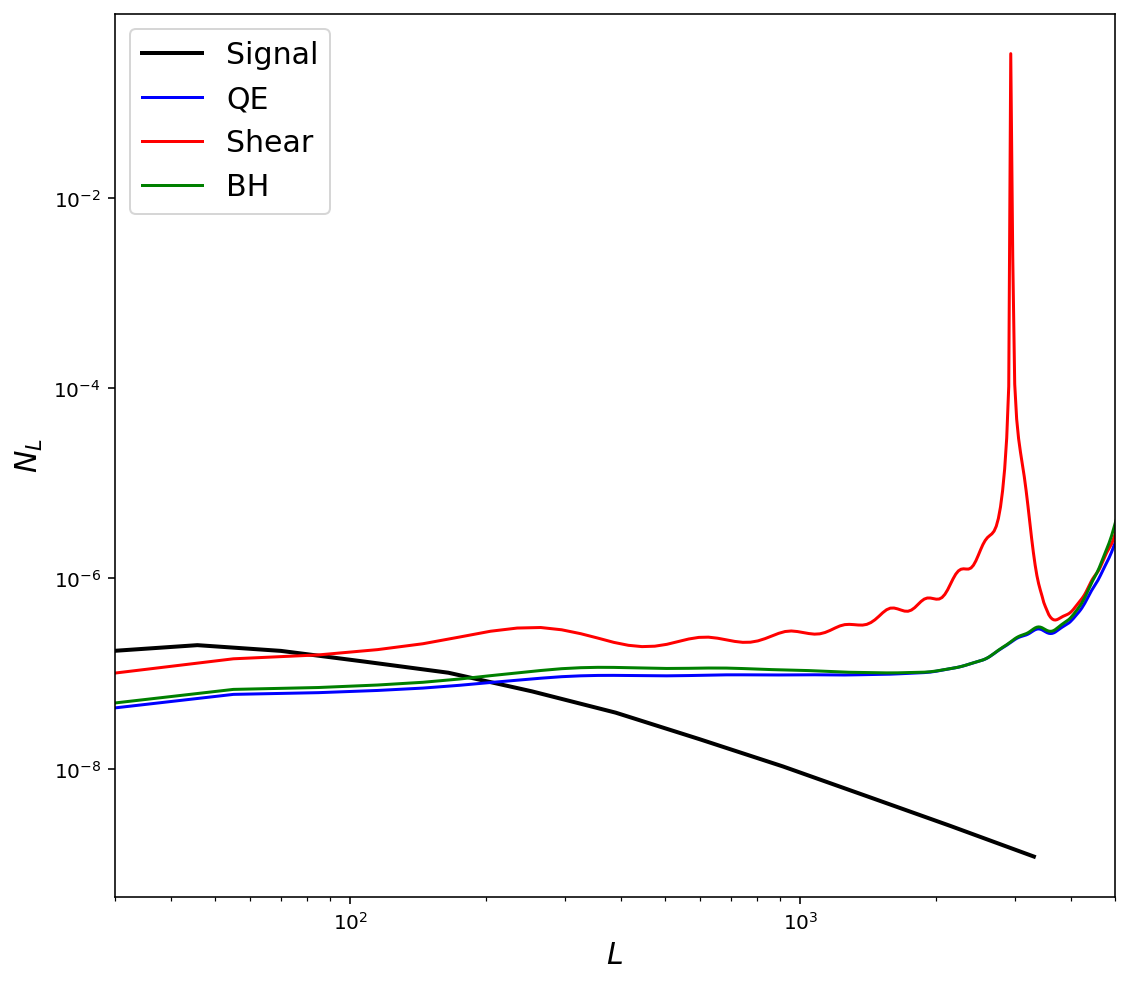

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)

ax.legend(prop = font)

fig.tight_layout()

fig.savefig(paperplots/'noises_3500.png', dpi = 300)
plt.show()

In [380]:
#ax[0].set_title(f'Best {names[i]}, h{h}_s{s}_b{b}', **csfont)
#fig.tight_layout()

In [381]:
lEdges = np.logspace(np.log10(10), np.log10(4000), 15, 10.)

In [382]:
deltal = lEdges[1:]-lEdges[:-1]

## Foregrounds biases

### Auto

In [383]:
fgnamefiles = ['tsz', 'cib', 'radiops', 'ksz', 'total']

In [384]:
lmax_fixed = 3500

In [385]:
foreground = {}
foreground['tsz'] = 'tSZ'
foreground['cib'] = 'CIB'
foreground['ksz'] = 'kSZ'
foreground['radiops'] = 'Radio'
foreground['total'] = 'Sum'

In [386]:
tri = 'Trispectrum'
pri = 'Primary'
pricross = 'Primary Cross'
sec = 'Secondary'
titles = [tri, pri, sec, pricross]

titles_tags = {}
titles_tags[tri] = trispectrumtag
titles_tags[pri] = primarytag
titles_tags[pricross] = primarycrosstag
titles_tags[sec] = secondarytag

In [387]:
ylims = {}

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.01
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.025

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[tri] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.1
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.1

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pri] = ylim

#######

ylim = {}

ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.01
ylim['ksz']['ymax'] = 0.01

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.01
ylim['radiops']['ymax'] = 0.01

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pricross] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.05

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.05
ylim['ksz']['ymax'] = 0.05

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.05
ylim['radiops']['ymax'] = 0.05

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[sec] = ylim

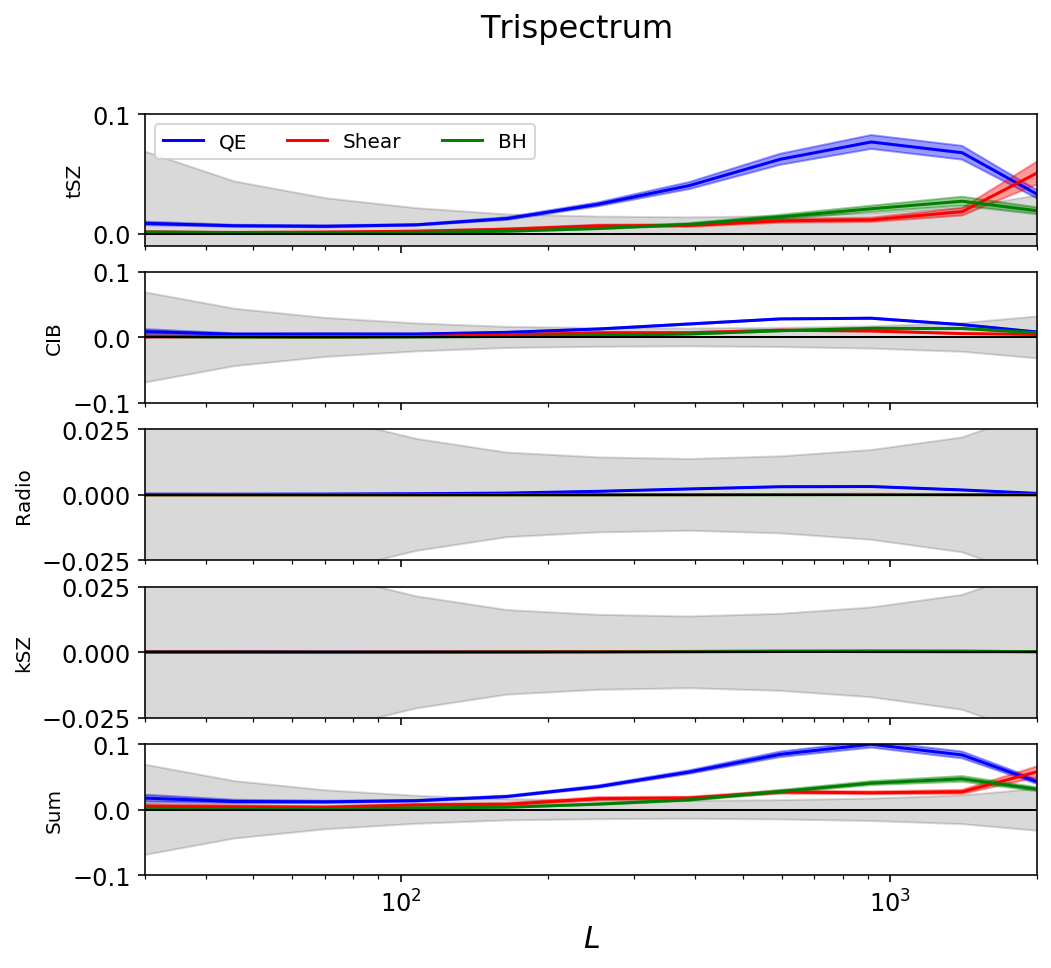

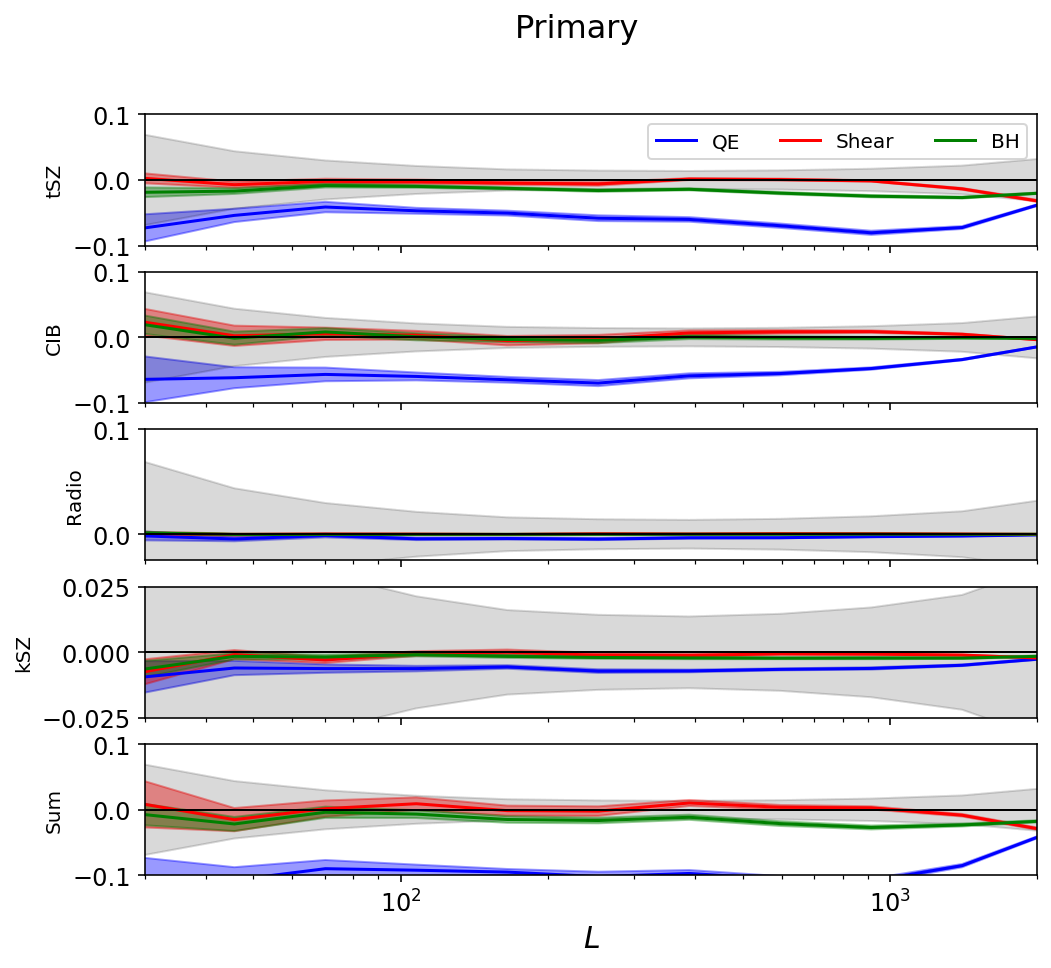

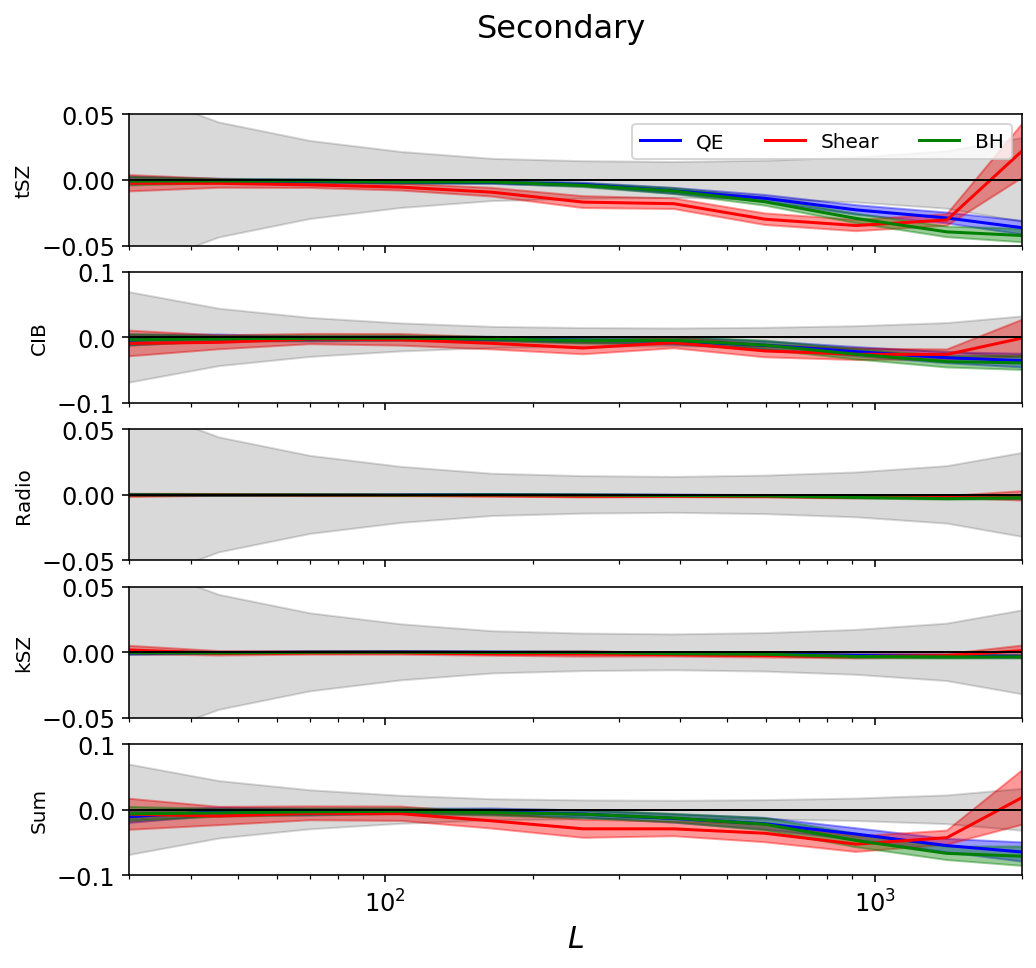

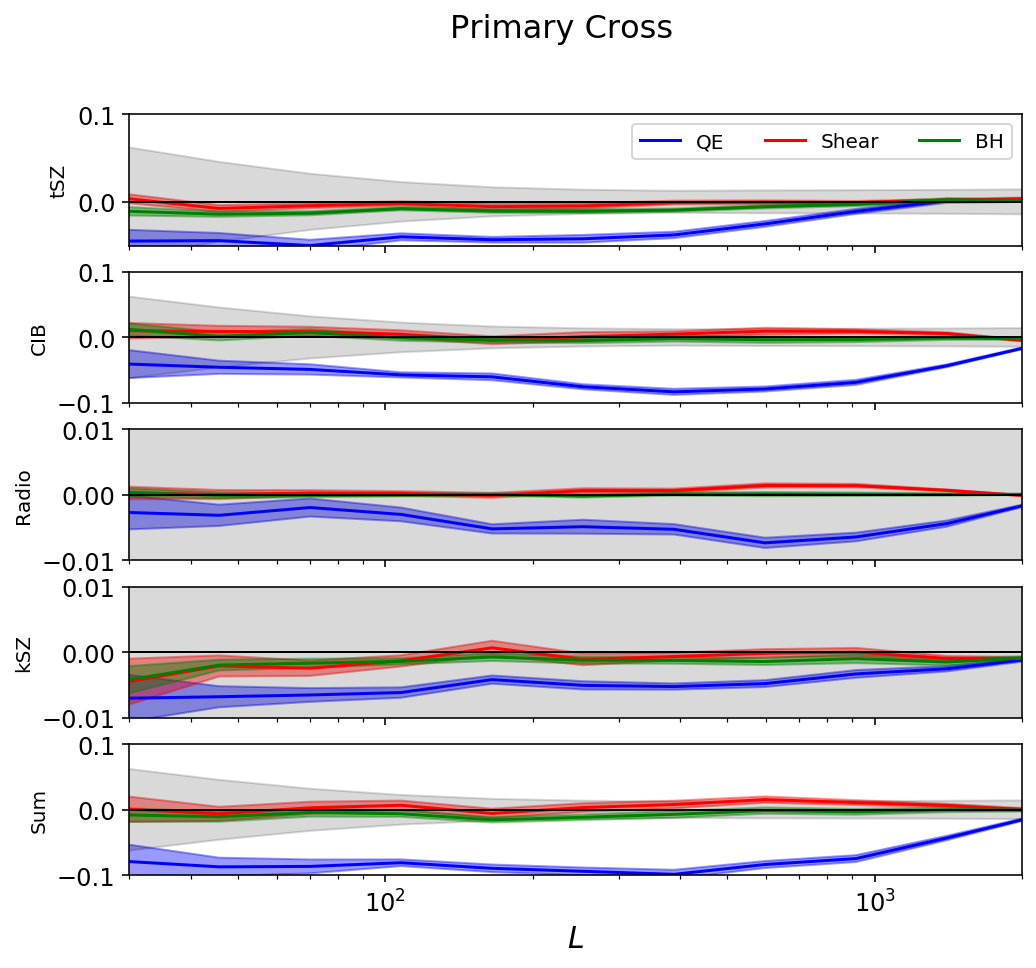

In [388]:
for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
    lmaxes_dict = {}
    lmax_directory = ''
    for e_index, e in enumerate(estimators):
        l = lmaxes[e_index]
        lmaxes_dict[e] = l
        lmax_directory += f'{names[e]}{l}'

    for t in titles:
        fig, ax = plt.subplots(nrows = len(fgnamefiles), ncols = 1, sharex = True, figsize = (8, 7))

        fig.suptitle(f'{t}', fontsize = 16, **csfont)

        #primary = get(primarytag)
        #secondary = get(secondarytag)
        #trispectrum = get(trispectrumtag)

        #primaryscatter = getscatter(primarytag)
        #secondaryscatter = getscatter(secondarytag)
        #trispectrumscatter = getscatter(trispectrumtag)

        for fgindex, fgnamefile in enumerate(fgnamefiles):
            
            P = PP/lmax_directory
            Pfg = PP/lmax_directory/fgnamefile

            getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
            get = lambda key: np.load(Pfg/getoutname(key))

            getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
            getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

            noises = get(noisetag)
            ells = get('ells')
            kk = get('kk')
            kg = get('kg')
            gg = get('gg')
        
            specificbias = get(titles_tags[t])
            specificscatter = getscatter(titles_tags[t])

            ylim = ylims[t]
            
            for e_index, e in enumerate(estimators):
                                
                    
                noise_k = noises[0, 0] #For QE
                kktot = kk+noise_k
                
                if specificscatter.ndim > 2:
                    err = specificscatter[e_index, e_index]/kk
                    y = specificbias[e_index, e_index]/kk
                    
                    stat_uncert = np.sqrt(2/(2*ells*deltal*fsky))*kktot/kk
                else:
                    err = specificscatter[e_index]/kg
                    y = specificbias[e_index]/kg
                    
                    stat_uncert = np.sqrt(1/(2*ells*deltal*fsky)*(kktot*gg+kg**2.))/kg
                

                ax[fgindex].plot(ells, y, color = colors_ests[e], label = labels_ests[e])
                ax[fgindex].fill_between(ells, y-err, y+err, color = colors_ests[e], alpha = 0.4)
                
                ax[fgindex].fill_between(ells, -stat_uncert, stat_uncert, color = 'black', alpha = 0.05)
                

                ax[fgindex].set_ylim(ymin = ylim[fgnamefile]['ymin'], ymax = ylim[fgnamefile]['ymax'])
                ax[fgindex].set_ylabel(f'{foreground[fgnamefile]}')
                ax[fgindex].set_ylim(ylim[fgnamefile]['ymin'], ylim[fgnamefile]['ymax'])
                ax[fgindex].set_xlim(30, 2000)
                ax[fgindex].axhline(y = 0, color = 'black', lw = 1)
                ax[fgindex].tick_params(axis = 'both', which = 'major', labelsize = 12)

        ax[-1].set_xscale('log')
        ax[-1].set_xlabel('$L$', size = 15)
        
        ax[0].legend(loc = "best", ncol = len(estimators))

        #fig.tight_layout()
        fig.savefig(paperplots/f'biases_{titles_tags[t]}_3500.png', dpi = 300)

        plt.show()

#### Cross check primary cross with Manu's code

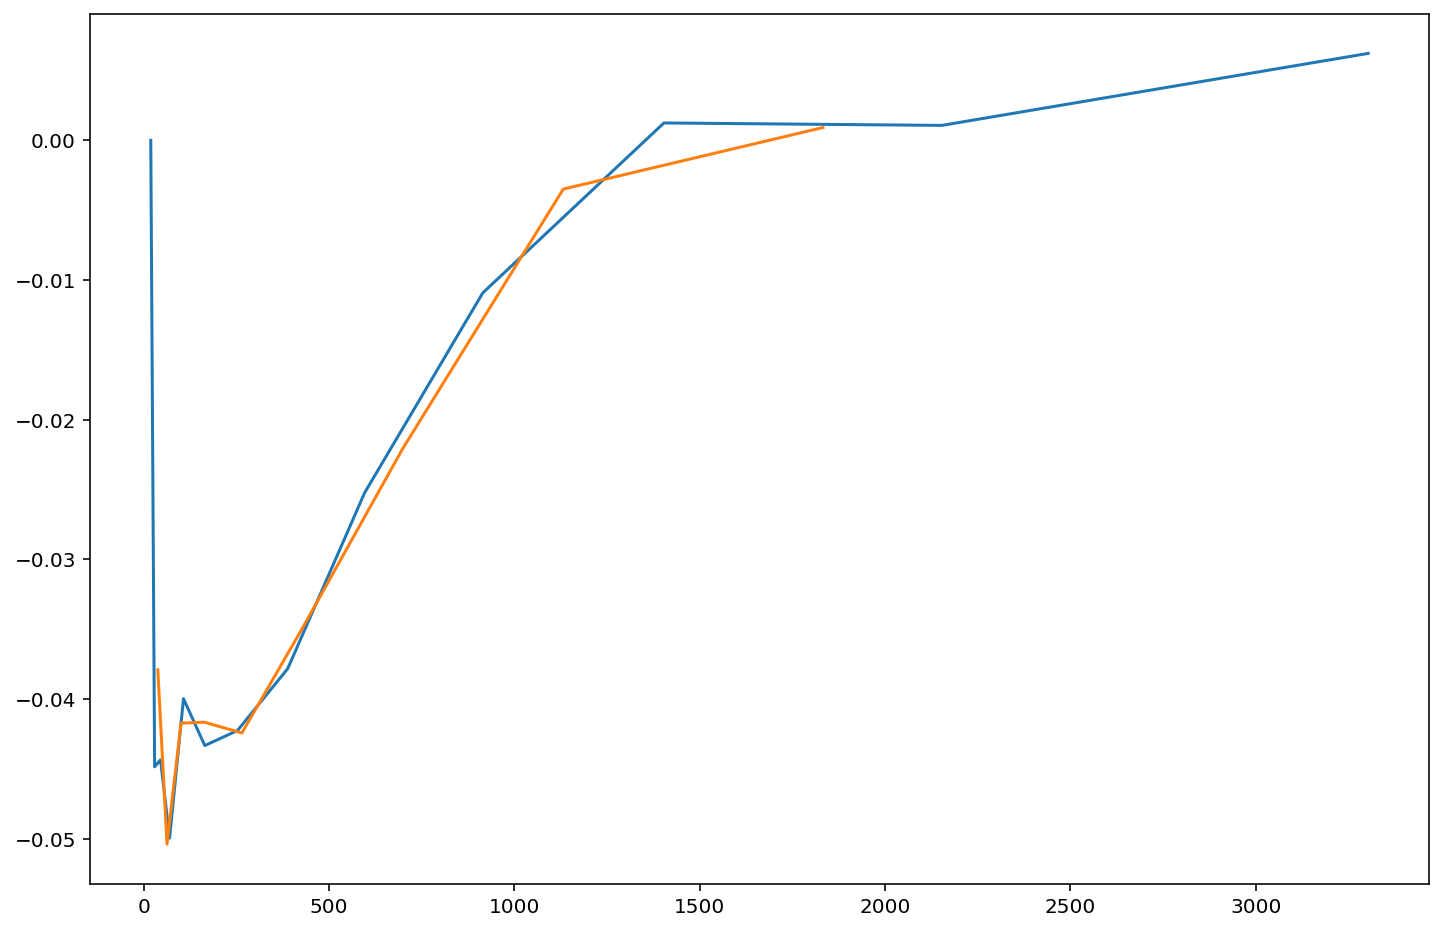

In [389]:
dictionary = u.dictionary(savingdirectory, 'h3500s3500b3500')

Nsims = 80
fgnamefile = 'tsz'

total = 0.
totalmanu = 0.
totalmanukg = 0.

for j in range(Nsims):
    dic = dictionary.read(f'{fgnamefile}_{nu}_{j}')
    total += dic['PC']['PC-hu_ok']
    
    direc = '/scratch/r/rbond/omard/CORI17112020/toNIAGARA24112020/LensQuEst-1/out_txt/'
    lCen, Clcross, signal = np.loadtxt(direc+f'QE_galonly_{j}.txt', unpack = True)
    totalmanu += Clcross
    totalmanukg += signal
    
total /= Nsims
totalmanu /= Nsims
totalmanukg /= Nsims

plt.plot(ells, total/kg)
selection = (lCen>30) & (lCen<2000)
plt.plot(lCen[selection], totalmanu[selection]/totalmanukg[selection])

### Alens parameter

In [390]:
import best

In [391]:
def get_lmax_directory(lmax_fixed, estimators):
    for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
        lmaxes_dict = {}
        lmax_directory = ''
        for e_index, e in enumerate(estimators):
            l = lmaxes[e_index]
            lmaxes_dict[e] = l
            lmax_directory += f'{names[e]}{l}'
        return lmax_directory

In [392]:
lmaxes_list = np.arange(2000, 5000, 500)

In [393]:
colors_fgs = {}
colors_fgs['tsz'] = 'red'
colors_fgs['cib'] = 'blue'
colors_fgs['ksz'] = 'green'
colors_fgs['radiops'] = 'gold'
colors_fgs['total'] = 'cyan'

In [394]:
labels_fgs = {}
labels_fgs['tsz'] = 'tSZ'
labels_fgs['cib'] = 'CIB'
labels_fgs['ksz'] = 'kSZ'
labels_fgs['radiops'] = 'Radio'
labels_fgs['total'] = 'Sum'

In [395]:
autocase = 'auto'
crosscase = 'cross'
cases = [autocase, crosscase]

Doing hu_ok
Doing shear
Doing bh


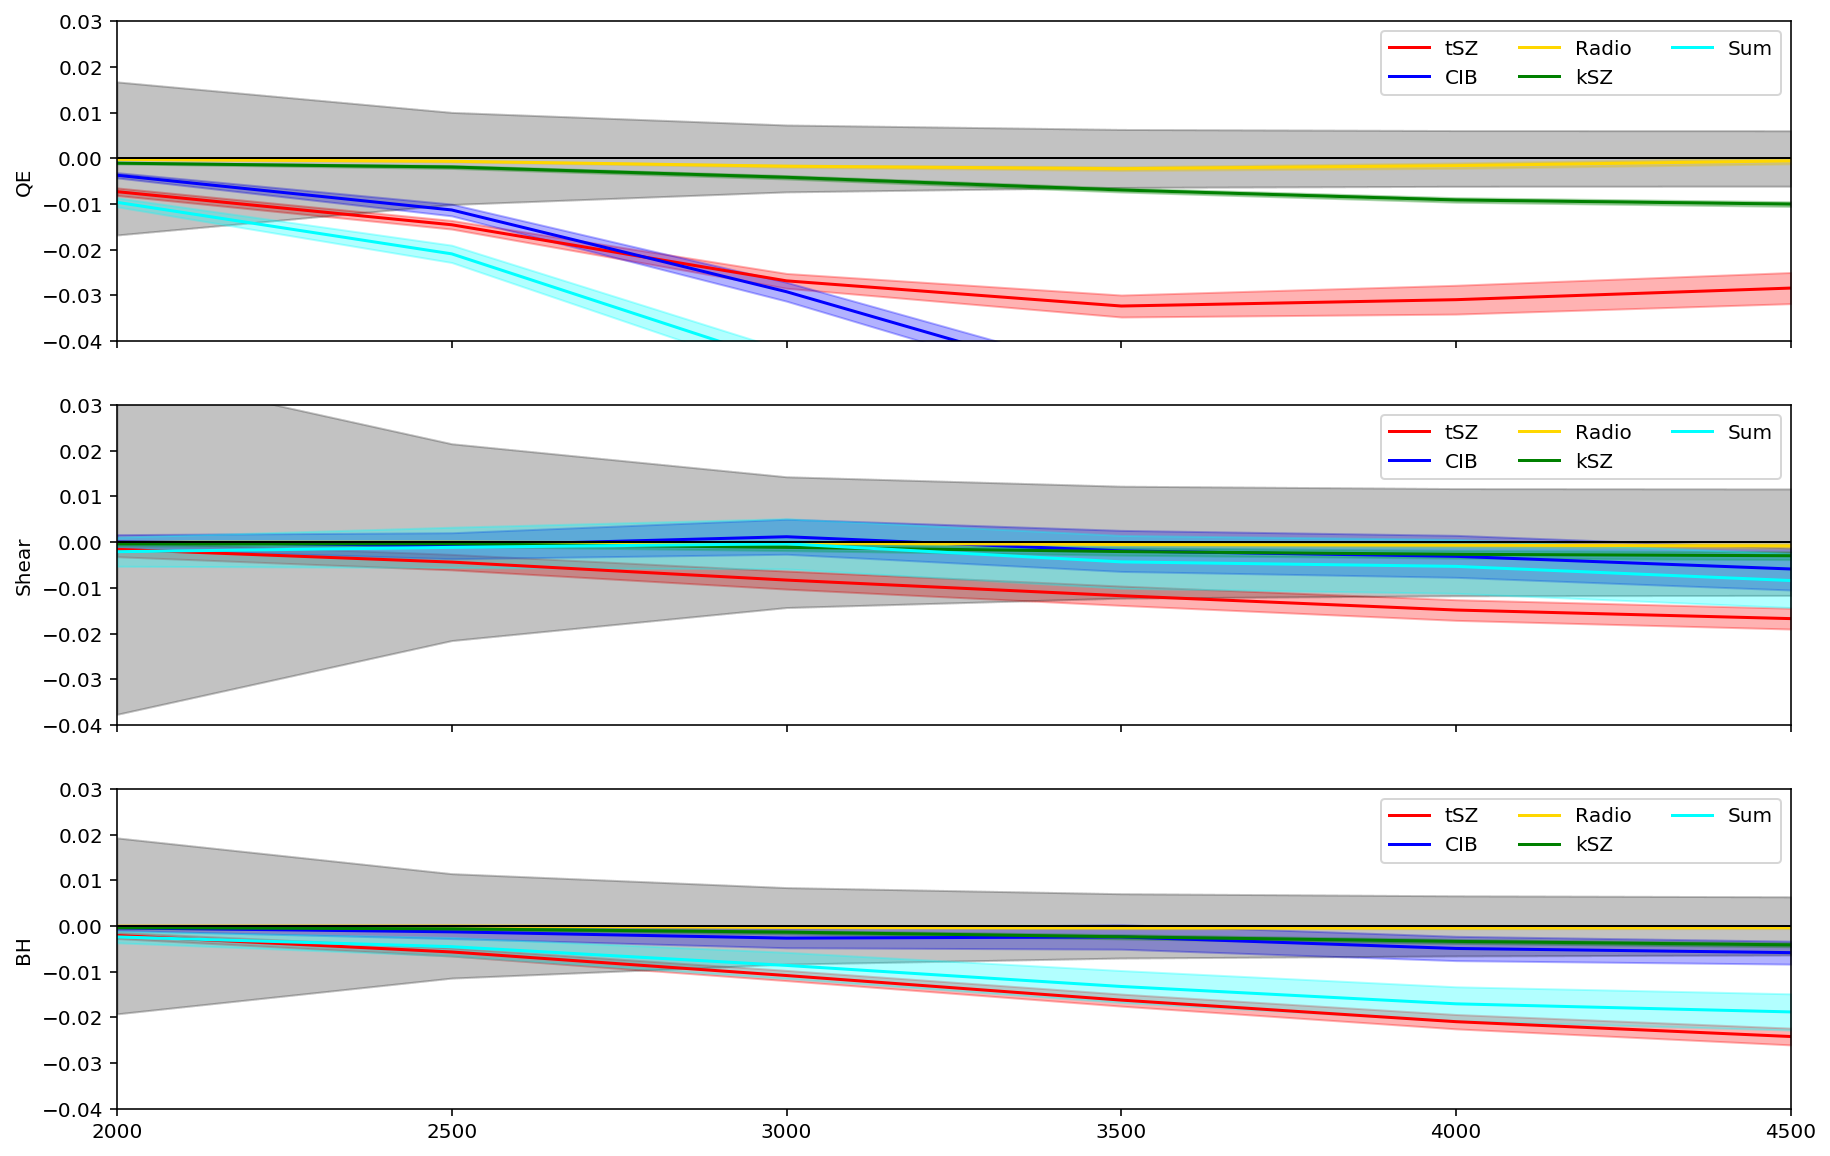

Doing hu_ok
Doing shear
Doing bh


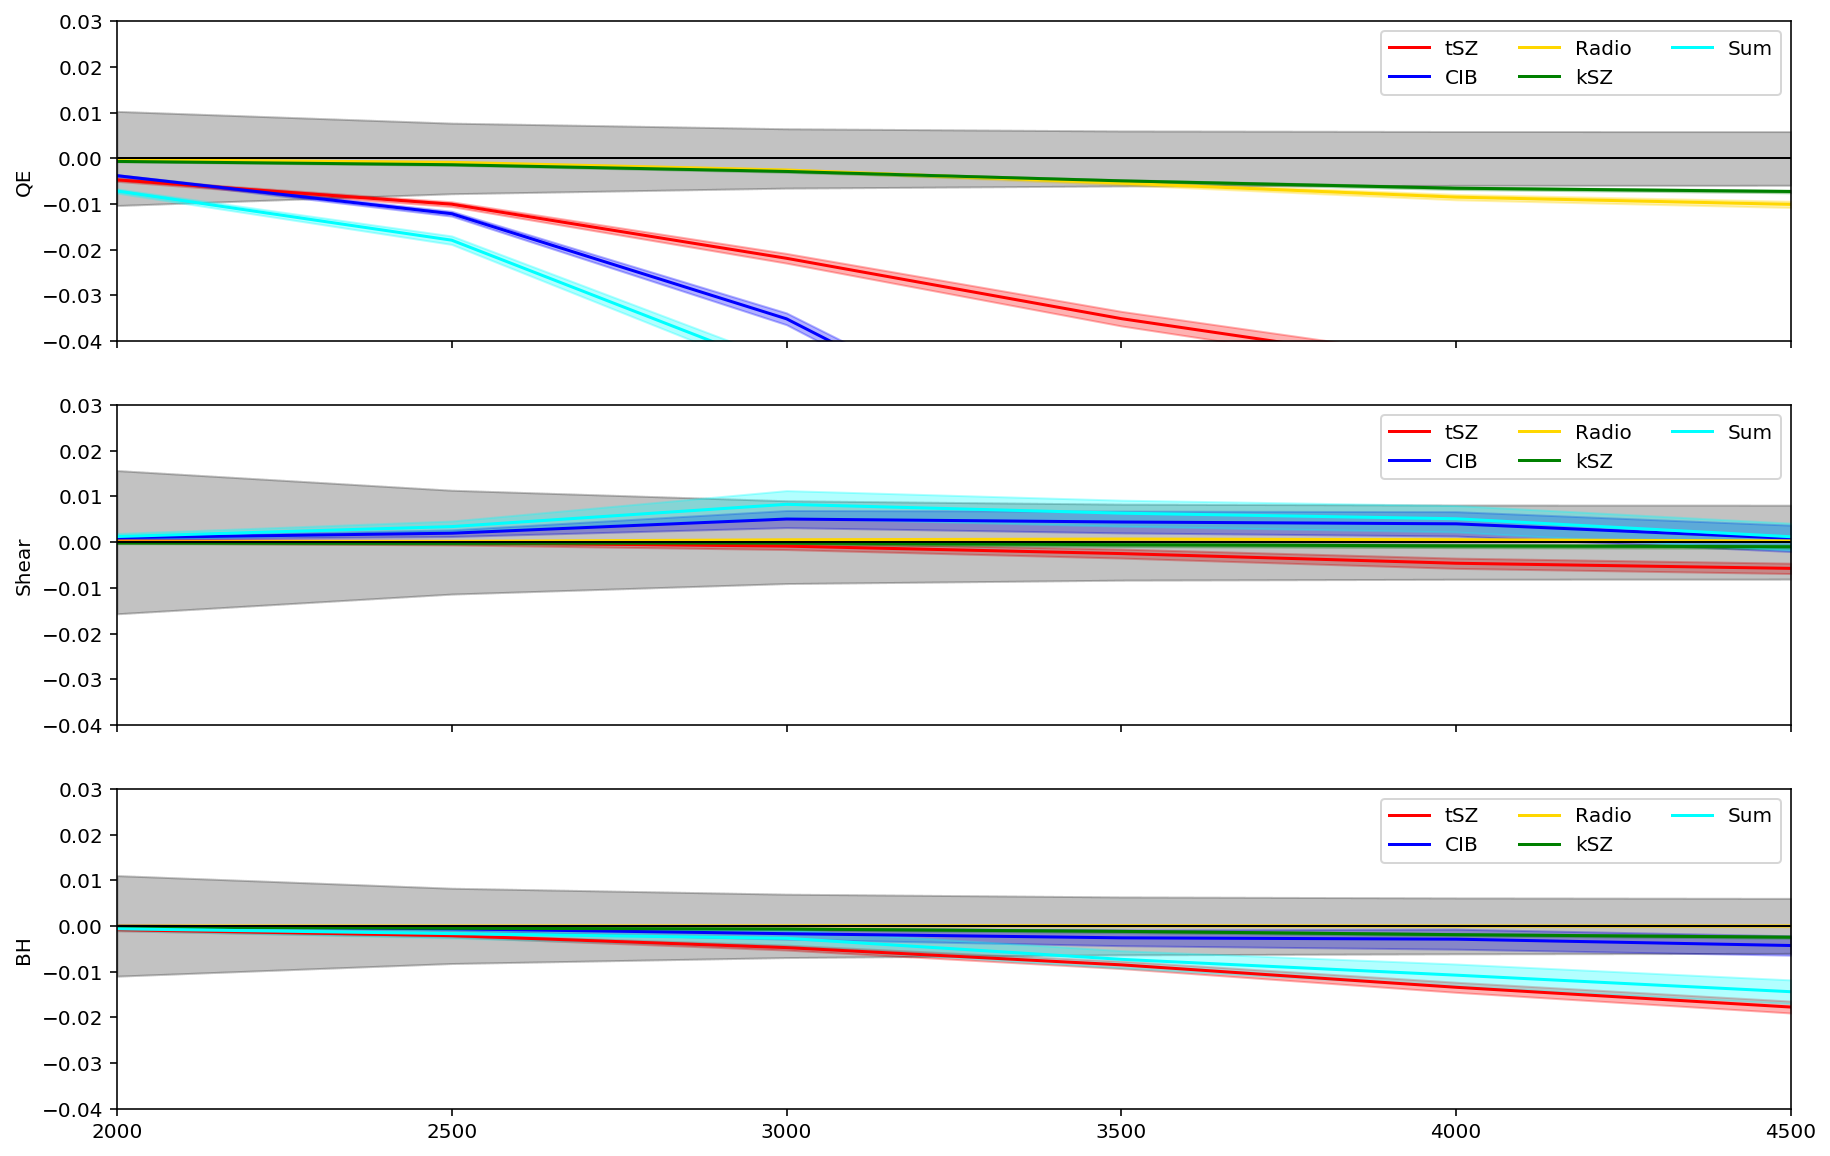

In [420]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))

    for index, estimator in enumerate(estimators):

        print(f'Doing {estimator}')

        for fgindex, fgnamefile in enumerate(fgnamefiles):

            noiseslist = []
            biaseslist = []
            
            scatters_list = []
            means_list = []

            for lmax_fixed in lmaxes_list: 

                lmax_directory = get_lmax_directory(lmax_fixed, estimators)
                
                P = PP/lmax_directory
                Pfg = PP/lmax_directory/fgnamefile

                getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                get = lambda key: np.load(Pfg/getoutname(key))

                getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                noises = get(noisetag)
                theta = get('theta')
                thetacross = get('thetacross')
                ells = get('ells')
                kk = get('kk')
                kg = get('kg')
                gg = get('gg')

                specificbias = get('totalbias')
                specificbiascross = get(primarycrosstag)
                
                #specificscatter = getscatter('totalbias')
                #specificscattercross = getscatter(primarycrosstag)
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                    Opt = Optauto
                elif case == crosscase:
                    Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, specificbiascross, noises)
                    Opt = Optcross

                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                nbins = Opt.nbins
                zeros = np.zeros(3*nbins)
                for j in range(nbins):
                    zeros[index+3*j:index+(3*j+1)] = 1.

                noiseslist += [n(zeros)]
                biaseslist += [b(zeros)]
                
                dic = u.dictionary('output_biases/', lmax_directory)
                
                biasestags = [trispectrumtag, primarytag, secondarytag]
                
                total = []

                for j in range(Nsims):
                    dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                    temp = 0.
                    if case == autocase:
                        for k in biasestags:
                            temp += (u.get_element(dictionary[k], estimators))
                    elif case == crosscase:
                        temp += (u.get_element(dictionary[primarycrosstag], estimators))
                        
                    temp_bias = temp
                    
                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                        Opt = Optauto
                    elif case == crosscase:
                        Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, temp_bias, noises)
                        Opt = Optcross
                        
                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                    
                    total += [b(zeros)]
                    
                A, A_octanct = 81*20**2, 5156.6
                factor_err = np.sqrt(A/A_octanct)
                    
                mean, scatter = u.get_mean_and_scatter(Nsims, total)
                
                scatters_list += [scatter]
                means_list += [mean]
                
                
                

            noiseslist = np.array(noiseslist)
            biaseslist = np.array(biaseslist)
            
            scatters_list = np.array(scatters_list)*factor_err
            means_list = np.array(means_list)
            
            #print('Rapp', means_list/biaseslist)
            #print(scatters_list)
            
            ax[index].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
            ax[index].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
            
            ax[index].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

        ax[index].axhline(y = 0, color = 'black', lw = 1)
        ax[index].set_ylim(-0.04, 0.03)
        ax[index].set_ylabel(labels_ests[estimator])
        ax[index].legend(ncol = len(estimators))
        ax[-1].set_xlim(2000, 4500)

    fig.savefig(paperplots/f'alens_{case}_biases.png', dpi = 300)
    plt.show()

PosixPath('output/h2000s2000b2000/tsz')

In [426]:
cases = ['auto']

In [ ]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))
        
    kind = 0
    
    for index, estimator in enumerate(estimators):
        
        for index2 in range(index+1, len(estimators)):
             

            estimator2 = estimators[index2]

            print(f'Doing {estimator}-{estimator2}')

            for fgindex, fgnamefile in enumerate(fgnamefiles):

                noiseslist = []
                biaseslist = []
                
                scatters_list = []
                means_list = []

                for lmax_fixed in lmaxes_list: 

                    lmax_directory = get_lmax_directory(lmax_fixed, estimators)


                    P = PP/lmax_directory
                    Pfg = PP/lmax_directory/fgnamefile

                    getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                    get = lambda key: np.load(Pfg/getoutname(key))

                    getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                    getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                    noises = get(noisetag)
                    theta = get('theta')
                    ells = get('ells')
                    kk = get('kk')
                    kg = get('kg')
                    gg = get('gg')

                    specificbias = get('totalbias')

                    #specificscatter = getscatter('totalbias')
                    
                    noises[index, index] *= 0.
                    theta[index, index, index, index] *= 0.
                    noises[index2, index2] *= 0.
                    theta[index2, index2, index2, index2] *= 0.
                    
                    specificbias[index, index] *= 0.
                    specificbias[index, index2] *= 0.

                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                        Opt = Optauto

                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                    nbins = Opt.nbins
                    zeros = np.zeros(3*nbins)
                    for j in range(nbins):
                        zeros[index+3*j:index+(3*j+1)] = 1./2.
                        zeros[index2+3*j:index2+(3*j+1)] = 1./2.

                    noiseslist += [n(zeros)]
                    biaseslist += [b(zeros)]
                    
                    dic = u.dictionary('output_biases/', lmax_directory)
                
                    biasestags = [trispectrumtag, primarytag, secondarytag]

                    total = []

                    for j in range(Nsims):
                        dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                        temp = 0.
                        if case == autocase:
                            for k in biasestags:
                                temp += (u.get_element(dictionary[k], estimators))
                                
                        temp_bias = temp
                        
                        temp_bias[index, index] *= 0.
                        temp_bias[index, index2] *= 0.

                        if case == autocase:
                            Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                            Opt = Optauto

                        f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                        total += [b(zeros)]

                    A, A_octanct = 81*20**2, 5156.6
                    factor_err = np.sqrt(A/A_octanct)

                    mean, scatter = u.get_mean_and_scatter(Nsims, total)

                    scatters_list += [scatter]
                    means_list += [mean]
                
                
                scatters_list = np.array(scatters_list)*factor_err
                means_list = np.array(means_list)

                noiseslist = np.array(noiseslist)
                biaseslist = np.array(biaseslist)
                ax[kind].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
                ax[kind].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
                
                ax[kind].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

            ax[kind].axhline(y = 0, color = 'black', lw = 1)
            ax[kind].set_ylim(-0.04, 0.03)
            ax[kind].set_ylabel(labels_ests[estimator]+'-'+labels_ests[estimator2])
            ax[kind].legend(ncol = len(estimators))
            ax[-1].set_xlim(2000, 4500)

            kind += 1
            
    fig.savefig(paperplots/f'alens_{case}_crosses_biases.png', dpi = 300)
    plt.show()

Doing hu_ok-shear
Doing hu_ok-bh


### SNR vs Bias

### Optimization

In [178]:
def get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalabsbias'))

    biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')

    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)

    dic.read(f'results_fb_{fb}')
    
    return dic

In [251]:
def get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalabsbias'))

    biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Optimizerkg = best.Opt(estimators, lmin_sel, lmax_sel, ells, kg, thetacross, biasescross, noises)
    
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')

    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)
    
    dic.read(f'results_fb_{fb}')
    
    wh = dic.dictionary['auto']['wh']
    ws = dic.dictionary['auto']['ws']
    wbh = dic.dictionary['auto']['wbh']
    wl = dic.dictionary['auto']['wl']
    
    
    a = np.c_[wh, ws, wbh]
    wsa = (wh, ws, wbh, wl)
    
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)
    
    
    wh = dic.dictionary['cross']['wh']
    ws = dic.dictionary['cross']['ws']
    wbh = dic.dictionary['cross']['wbh']
    wl = dic.dictionary['cross']['wl']
    
    wsc = (wh, ws, wbh, wl)
    
    a = np.c_[wh, ws, wbh]
    
    combinedcn = Optimizerkg.get_bias_part(a, Optimizerkg.noises_selected)
    combinedcb = Optimizerkg.get_bias_part(a, Optimizerkg.biases_selected)
    
    return wsa, wsc, Optimizerkk, Optimizerkg, combinedn, combinedb, combinedcn, combinedcb

In [252]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)


def get_est_weights(Opt, index, invvar):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
   '''
    nbins = Opt.nbins
    zeros = np.zeros(3*nbins)
    for j in range(nbins):
        zeros[index+3*j:index+(3*j+1)] = 1.
    return zeros

In [253]:

def get_ws(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):

    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    w1, w2, w3, wl = dic.dictionary['auto']['wh'], dic.dictionary['auto']['ws'], dic.dictionary['auto']['wbh'], dic.dictionary['auto']['wl']

    w1c, w2c, w3c, wlc = dic.dictionary['cross']['wh'], dic.dictionary['cross']['ws'], dic.dictionary['cross']['wbh'], dic.dictionary['cross']['wl']
    
    return dic.dictionary['ells'], w1, w2, w3, wl, w1c, w2c, w3c, wlc



def get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['total'], dic.dictionary['cross']['total']
    return auto, cross

def get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['noise'], dic.dictionary['cross']['noise']
    return auto, cross

def get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['bias'], dic.dictionary['cross']['bias']
    return auto, cross

In [342]:
def plot_fixed(fb, all_lmaxes_directories):
        fig, ax = plt.subplots(nrows = 4, sharex = True)

        fig2, ax2 = plt.subplots(nrows = 3, sharex = True)

        fig.suptitle(f'Case of fb = {fb}')

        fig2.suptitle(f'Cross Case of fb = {fb}')

        for fgnamefile in [fgnamefiles[0]]:
            for allmaxes in all_lmaxes_directories:
                print(allmaxes)
                h, s, b = re.findall(r'\d+', allmaxes)
                lmaxes_configs = [(h, s, b)]
                for lmaxes in lmaxes_configs:
                    lmaxes_dict = {}
                    lmax_directory = ''
                    for e_index, e in enumerate(estimators):
                        l = lmaxes[e_index]
                        lmaxes_dict[e] = l
                        lmax_directory += f'{names[e]}{l}'

                    #print('Doing for', lmax_directory)
                    invvariance = False
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)

                    ells = Opt.ells_selected

                    b = Opt.biases_selected
                    n = Opt.noises_selected

                    ax[0].plot(ells, combinedb, color = 'purple', label = 'Combined', marker = 'o')
                    ax[0].plot(ells, b[0, 0], color = 'blue', label = 'H')
                    ax[0].plot(ells, b[1, 1], color = 'red', label = 'S')
                    ax[0].plot(ells, b[2, 2], color = 'green', label = 'B')

                    ax[1].plot(ells, combinedn, color = 'purple', label = 'Combined', marker = 'o')
                    ax[1].plot(ells, n[0, 0], color = 'blue', label = 'H')
                    ax[1].plot(ells, n[1, 1], color = 'red', label = 'S')
                    ax[1].plot(ells, n[2, 2], color = 'green', label = 'B')

                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', label = 'H')
                    ax[2].plot(ells, w2, color = 'red', label = 'S')
                    ax[2].plot(ells, w3, color = 'green', label = 'B')

                    ax[3].plot(ells, wl*ells, color = 'black')


                    b = Optkg.biases_selected
                    n = Optkg.noises_selected

                    w1, w2, w3, wl = wsc

                    ax2[0].plot(ells, combinedcb, color = 'purple', label = 'Combined', marker = 'o')
                    ax2[0].plot(ells, b[0], color = 'blue', label = 'H')
                    ax2[0].plot(ells, b[1], color = 'red', label = 'S')
                    ax2[0].plot(ells, b[2], color = 'green', label = 'B')


                    ax2[1].plot(ells, w1, color = 'blue', label = 'H')
                    ax2[1].plot(ells, w2, color = 'red', label = 'S')
                    ax2[1].plot(ells, w3, color = 'green', label = 'B')

                    ax2[2].plot(ells, wl*ells, color = 'black')


                    invvariance = True
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)


                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax[3].plot(ells, wl*ells, color = 'black', ls = '--', alpha = 0.4)

                    w1, w2, w3, wl = wsc

                    ax2[1].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax2[2].plot(ells, wl*ells, color = 'black', ls = '--', alpha = 0.4)


        ax[0].set_ylabel('$B$')
        ax[1].set_ylabel('$N$')
        ax[2].set_ylabel('$W$')
        ax[3].set_ylabel('$W_L$')
        ax[0].set_xscale('log')
        ax[0].legend(ncol = 4)

        ax2[0].set_ylabel('$B$')
        ax2[1].set_ylabel('$W$')
        ax2[2].set_ylabel('$W_L$')
        ax2[0].set_xscale('log')
        ax2[0].legend(ncol = 4)

        plt.show()




#### Check a fixed config

In [343]:
fbs = [0., 1.]

In [344]:
all_lmaxes_directories = ['h3500s3500b3500']

h3500s3500b3500


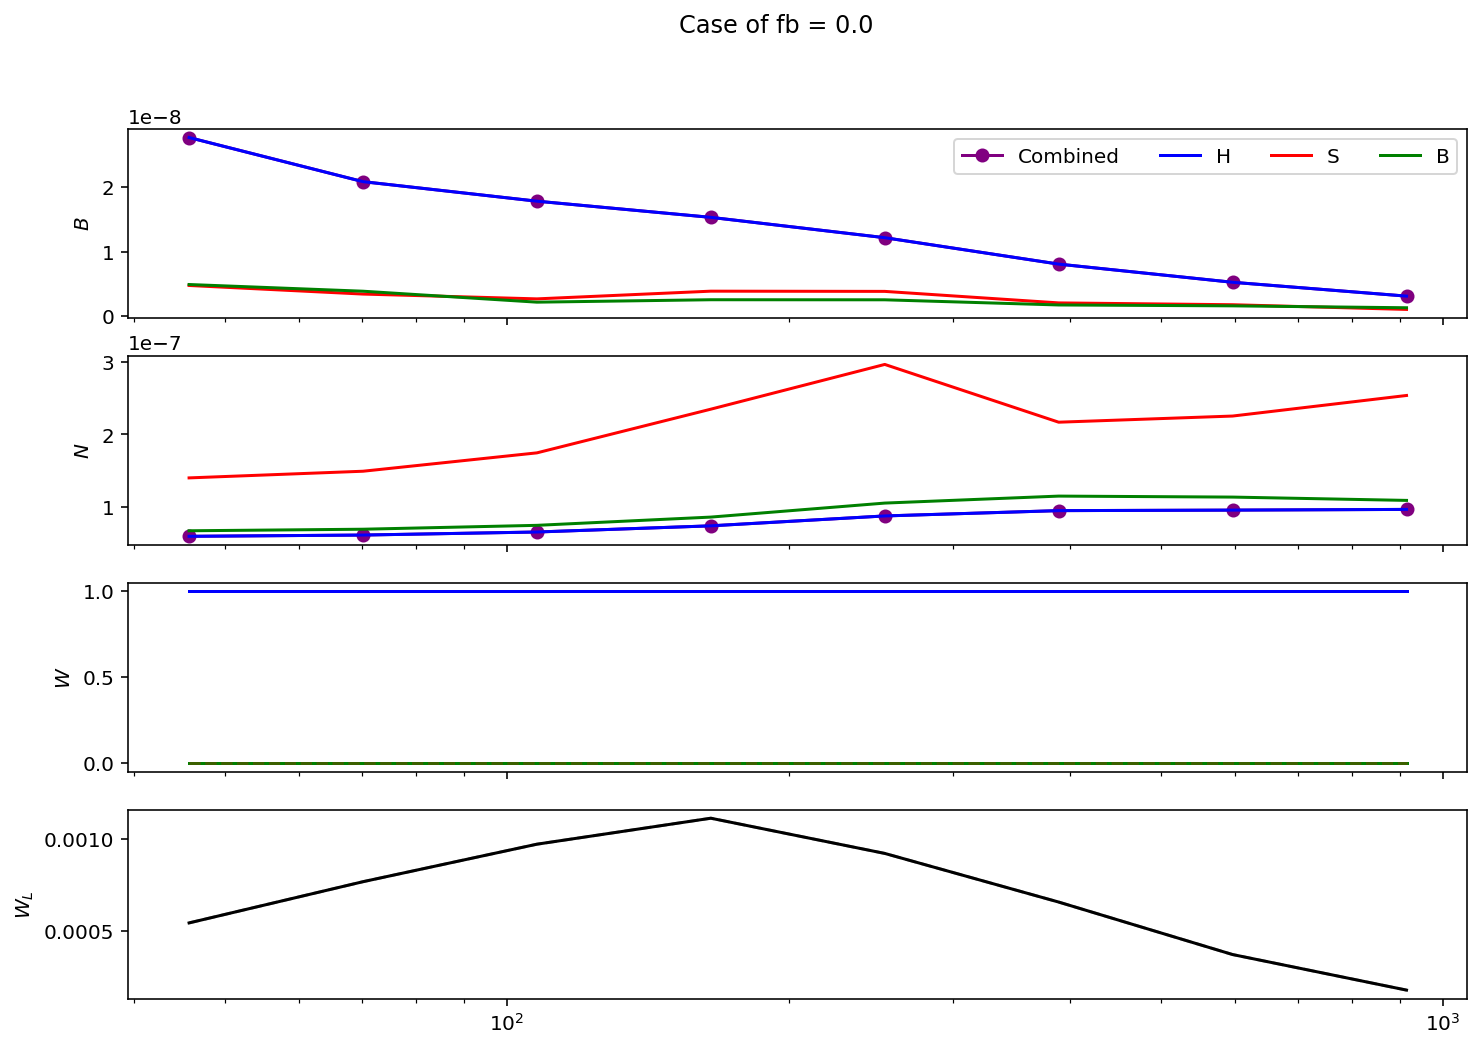

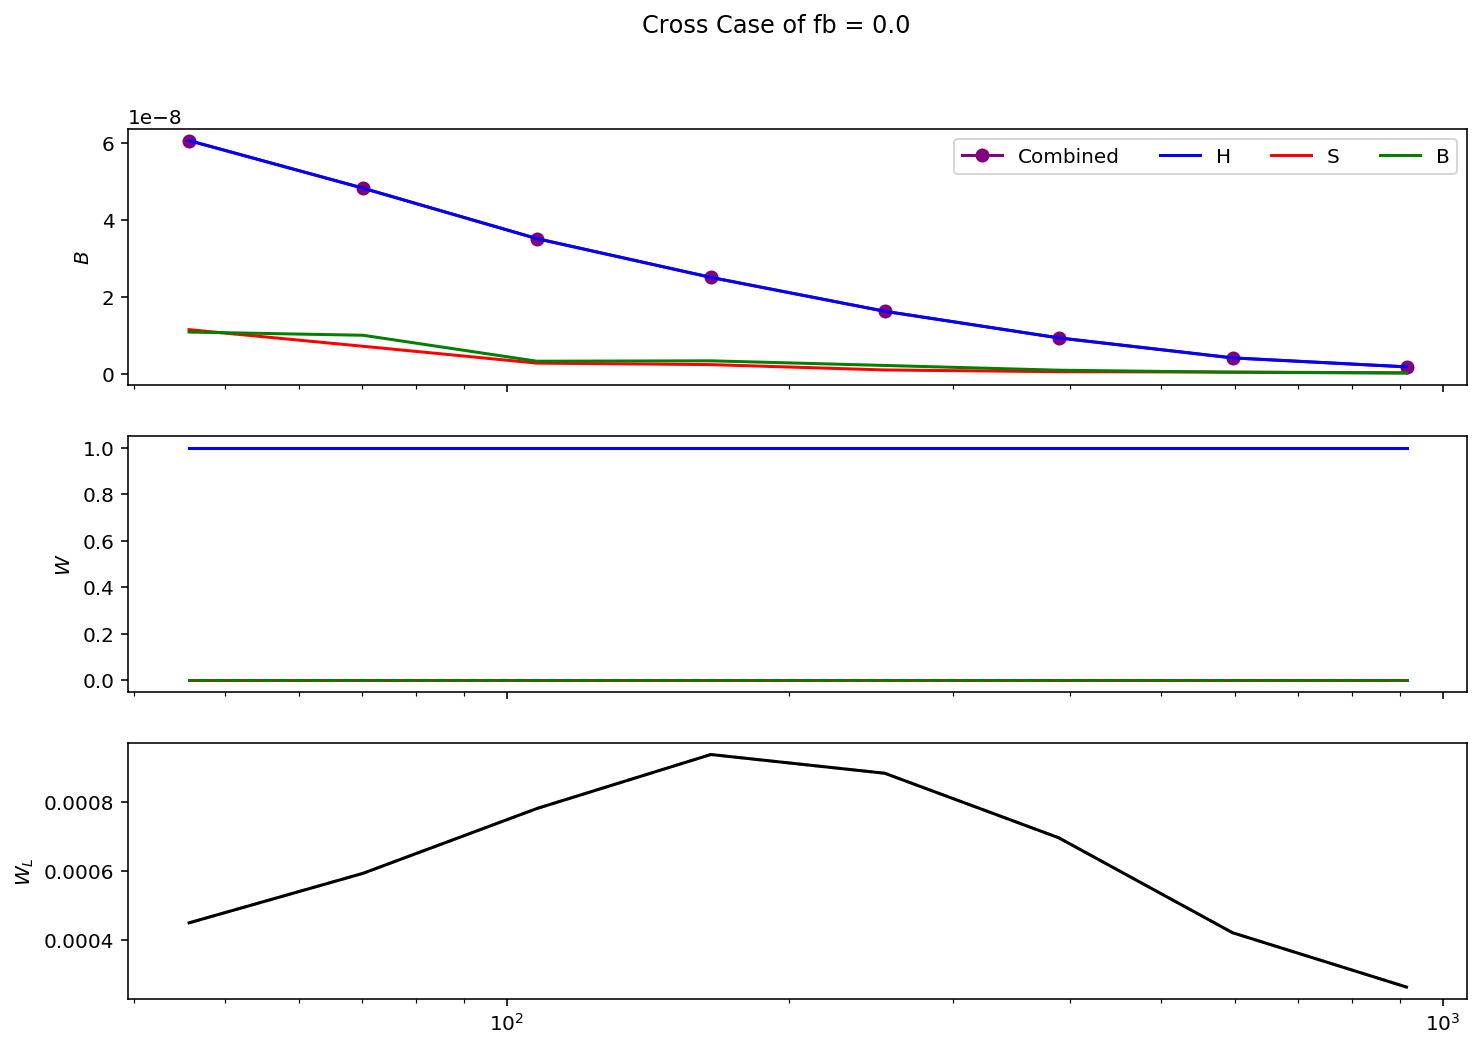

h3500s3500b3500


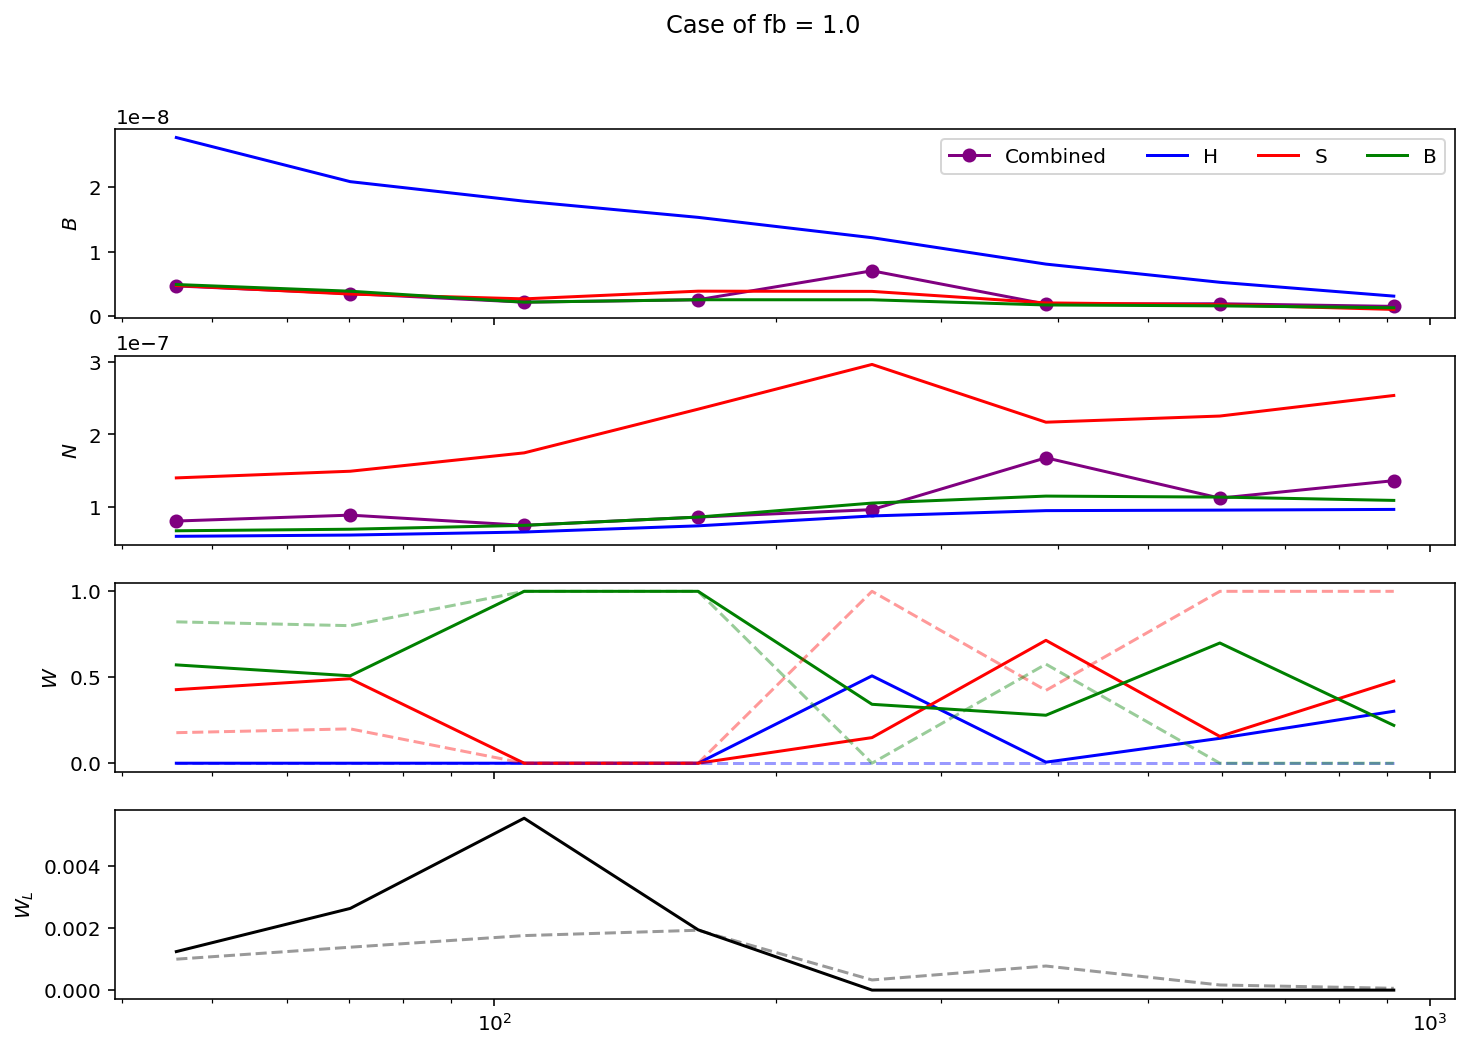

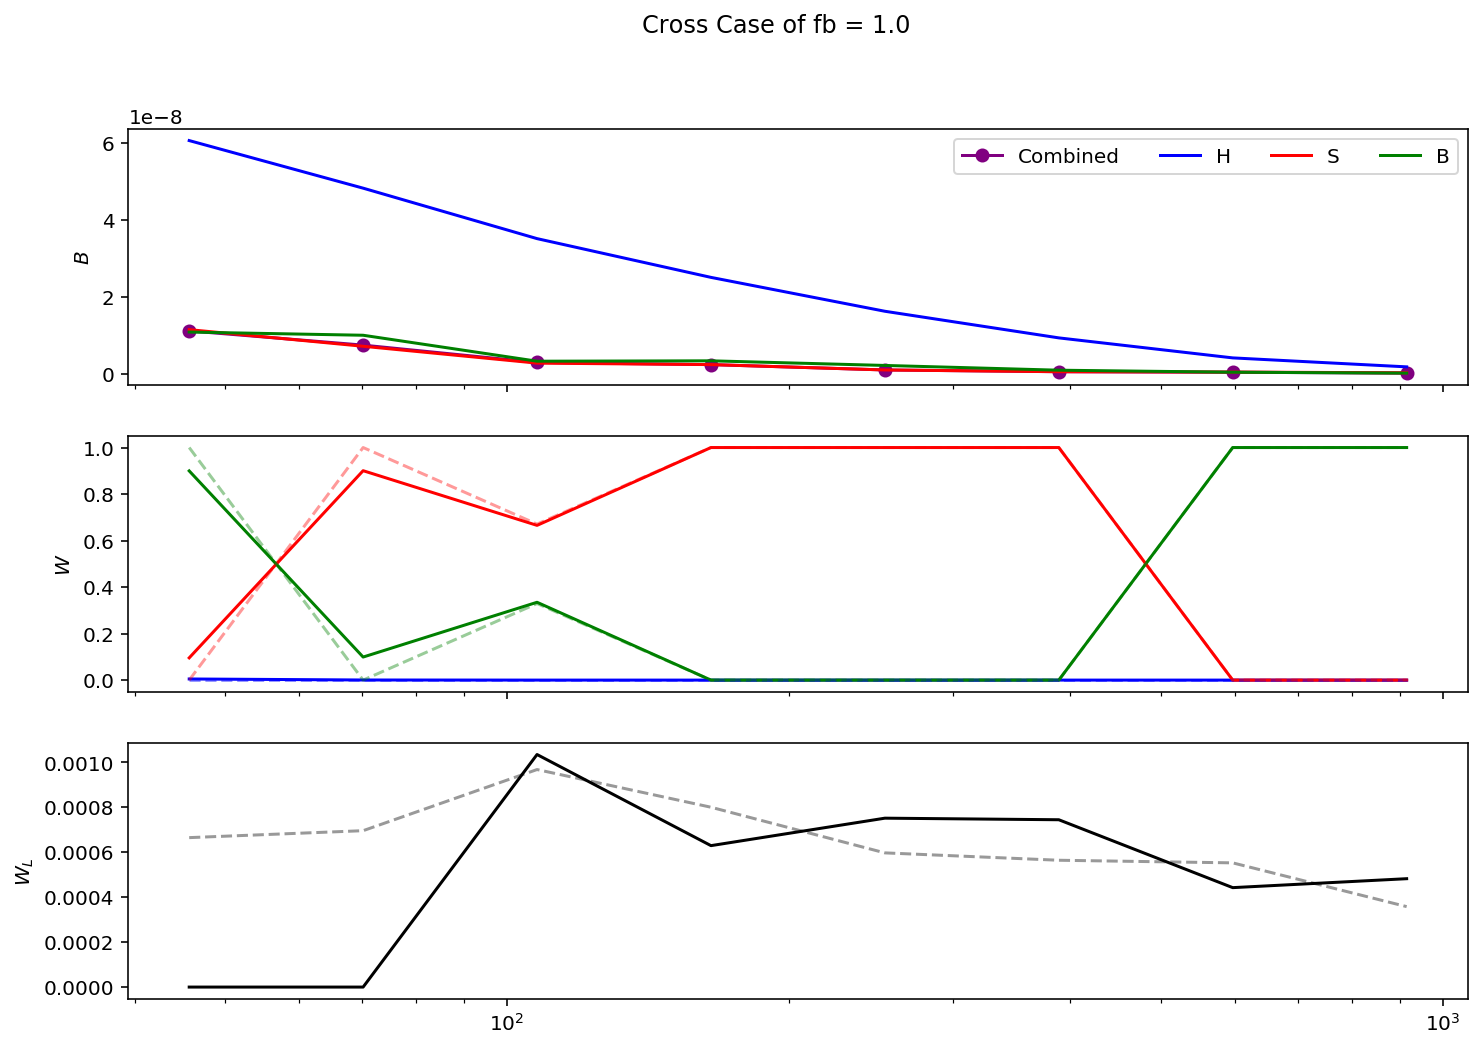

In [345]:
for fb in fbs:
    plot_fixed(fb, all_lmaxes_directories)

#### Run min for fb = 0., fb = 1.

In [291]:
path = pathlib.Path('output/')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]

In [305]:
invvariance = False

In [306]:
fb = 1.

In [329]:
autos = {}
crosses = {}

la = []
lc = []

lamv = []
lcmv = []

autosn = {}
crossesn = {}

lan = []
lcn = []

autosb = {}
crossesb = {}

lab = []
lcb = []

for fgnamefile in [fgnamefiles[0]]:
    for lmax_directory in all_lmaxes_directories:
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autos[lmax_directory] = a
            crosses[lmax_directory] = c
            
            la += [a]
            lc += [c]
            
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)
            
            lamv += [a]
            lcmv += [c]
            
            a, c = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosb[lmax_directory] = a
            crossesb[lmax_directory] = c
            
            lab += [a]
            lcb += [c]
            
            a, c = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosn[lmax_directory] = a
            crossesn[lmax_directory] = c
            
            lan += [a]
            lcn += [c]

In [330]:
import pandas

In [331]:
data = {}
data['Name'] = all_lmaxes_directories
data['Total Auto'] = la
data['Total Cross'] = lc

data['Total Mv Auto'] = lamv
data['Total Mv Cross'] = lcmv

data['Bias Auto'] = lab
data['Noise Auto'] = lan
data['Detectable Auto'] = np.array(lab)>np.array(lan)


data['Bias Cross'] = lcb
data['Noise Cross'] = lcn
data['Detectable Cross'] = np.array(lcb)>np.array(lcn)

In [332]:
df = pandas.DataFrame(data)
df

,Name,Total Auto,Total Cross,Total Mv Auto,Total Mv Cross,Bias Auto,Noise Auto,Detectable Auto,Bias Cross,Noise Cross,Detectable Cross
0,h3500s3500b4500,0.000926,0.000154,0.002252,0.000163,0.023063,0.019855,True,0.008800,0.008753,True
1,h4500s4000b4000,0.000932,0.000170,0.002717,0.000183,0.024584,0.018105,True,0.009677,0.008725,True
2,h3500s4000b3000,0.000291,0.000094,0.000693,0.000098,0.012401,0.011734,True,0.006264,0.007401,False
3,h4000s4000b3500,0.000573,0.000142,0.001637,0.000154,0.019741,0.013550,True,0.008856,0.008001,True
4,h2500s2000b2000,0.000350,0.000116,0.000352,0.000117,0.008433,0.016697,False,0.003098,0.010326,False
...,...,...,...,...,...,...,...,...,...,...,...
123,h4000s4500b3000,0.000291,0.000094,0.000703,0.000098,0.012401,0.011734,True,0.006337,0.007345,False
124,h2500s4000b4500,0.000753,0.000169,0.001347,0.000182,0.022193,0.016145,True,0.009662,0.008727,True
125,h4500s3500b3000,0.000291,0.000090,0.000654,0.000091,0.012401,0.011734,True,0.006136,0.007215,False
126,h3500s4000b3500,0.000573,0.000142,0.001637,0.000154,0.019741,0.013550,True,0.008856,0.008001,True


In [351]:
0.007827**2+0.012507**2

0.00021768697800000002

In [341]:
df.sort_values('Total Mv Auto')

,Name,Total Auto,Total Cross,Total Mv Auto,Total Mv Cross,Bias Auto,Noise Auto,Detectable Auto,Bias Cross,Noise Cross,Detectable Cross
44,h2500s2000b2500,0.000218,0.000079,0.000226,0.000080,0.007827,0.012507,False,0.003323,0.008268,False
29,h2000s2000b2500,0.000218,0.000079,0.000226,0.000080,0.007847,0.012493,False,0.003323,0.008268,False
57,h2000s3000b2500,0.000219,0.000077,0.000233,0.000077,0.008163,0.012336,False,0.003482,0.008025,False
46,h2000s2500b2500,0.000219,0.000079,0.000234,0.000079,0.008028,0.012447,False,0.003281,0.008278,False
22,h2000s4000b2500,0.000220,0.000079,0.000234,0.000080,0.008076,0.012436,False,0.003556,0.008170,False
...,...,...,...,...,...,...,...,...,...,...,...
30,h4500s4000b4500,0.001007,0.000170,0.003099,0.000183,0.023515,0.021313,True,0.009642,0.008764,True
95,h3000s4500b4500,0.001082,0.000143,0.003463,0.000156,0.025139,0.021222,True,0.008165,0.008734,False
66,h3500s4500b4500,0.001082,0.000143,0.003463,0.000156,0.025139,0.021222,True,0.008165,0.008734,False
33,h4500s4500b4500,0.001082,0.000143,0.003463,0.000156,0.025139,0.021222,True,0.008165,0.008734,False


h2000s2000b2500


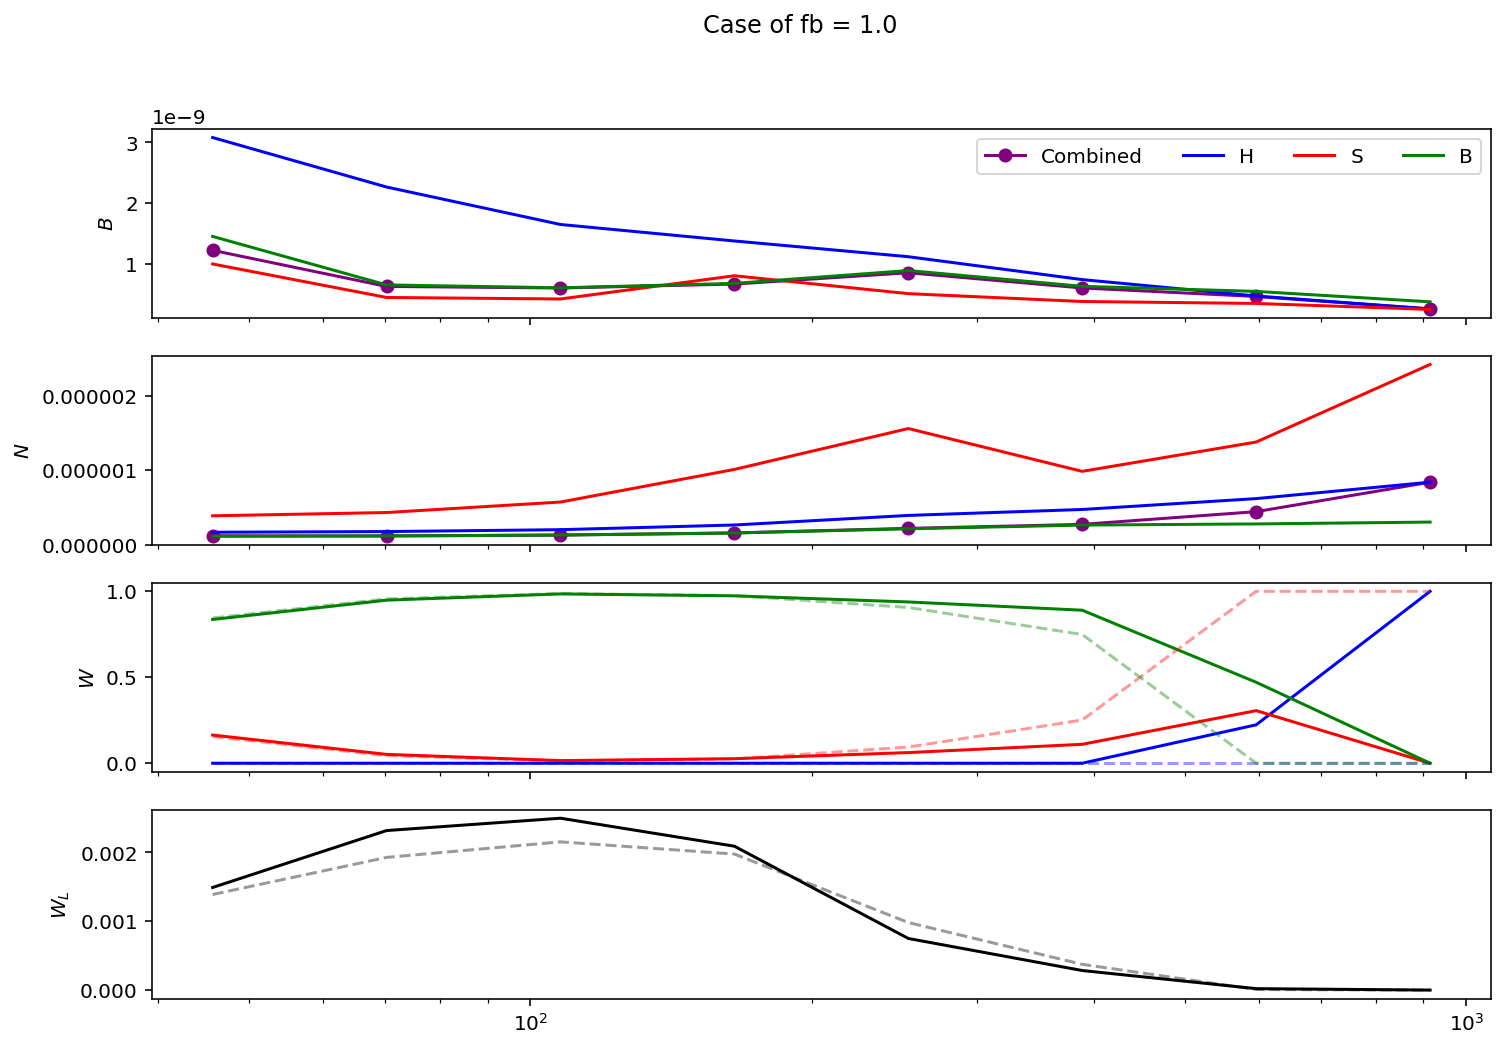

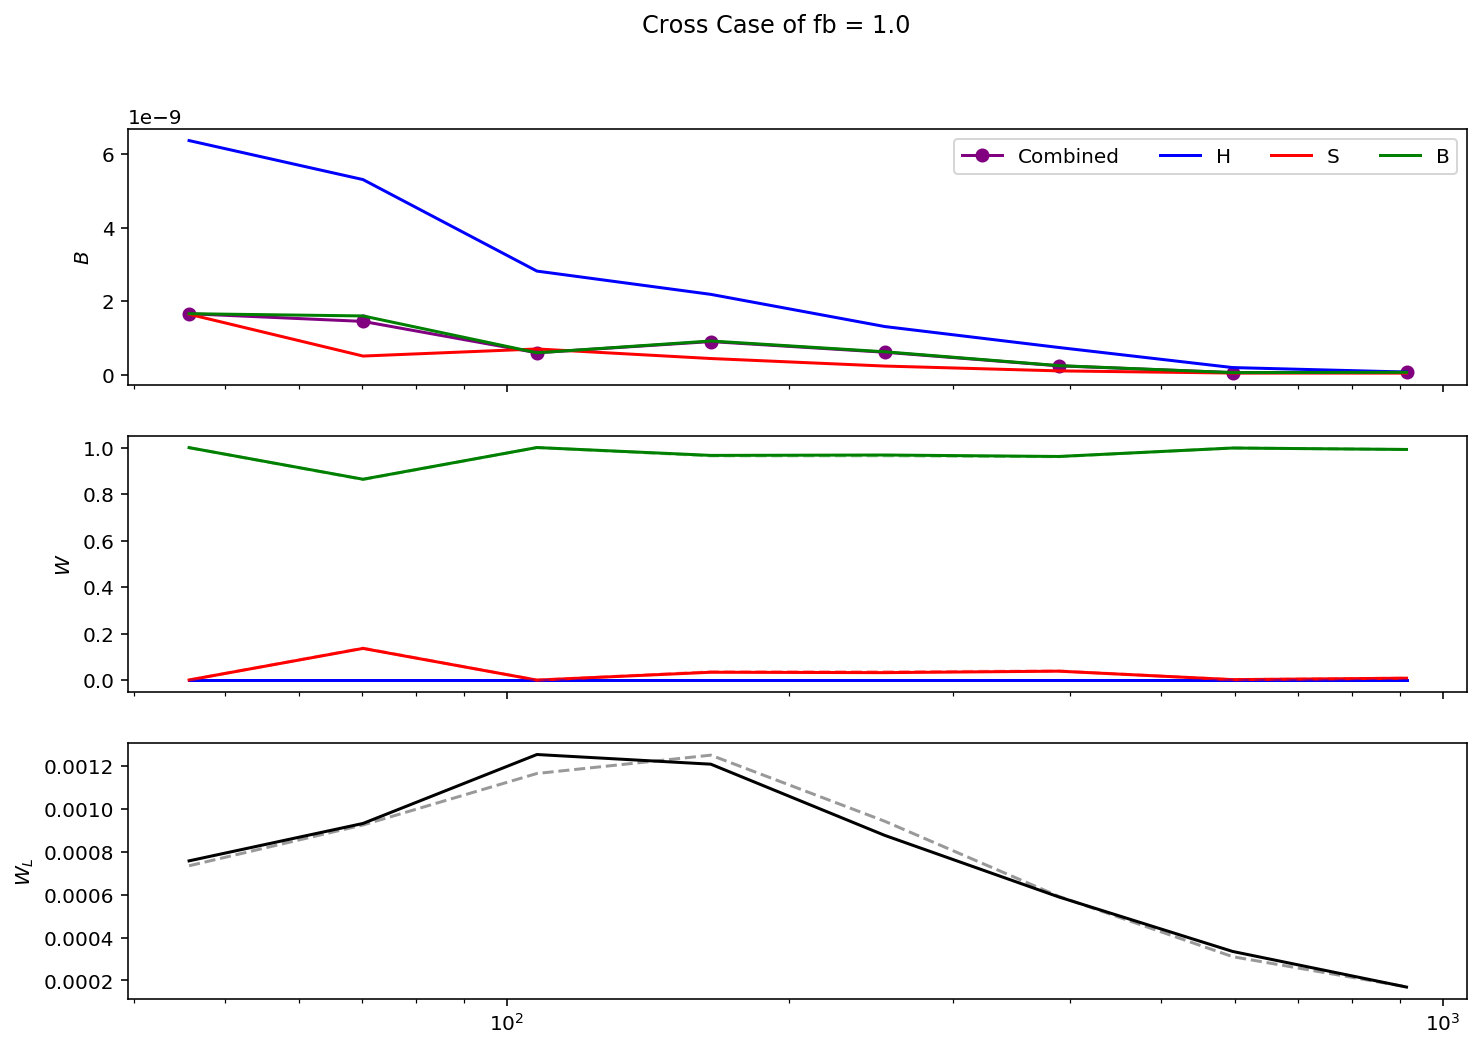

In [346]:
directory = min(autos, key = autos.get)
all_maxes = [directory]
plot_fixed(fb, all_maxes)

In [336]:
#autos_sorted = {k: v for k, v in sorted(autos.items(), key = lambda item: item[1])}

In [337]:
#autos_sorted

h2000s2000b2500


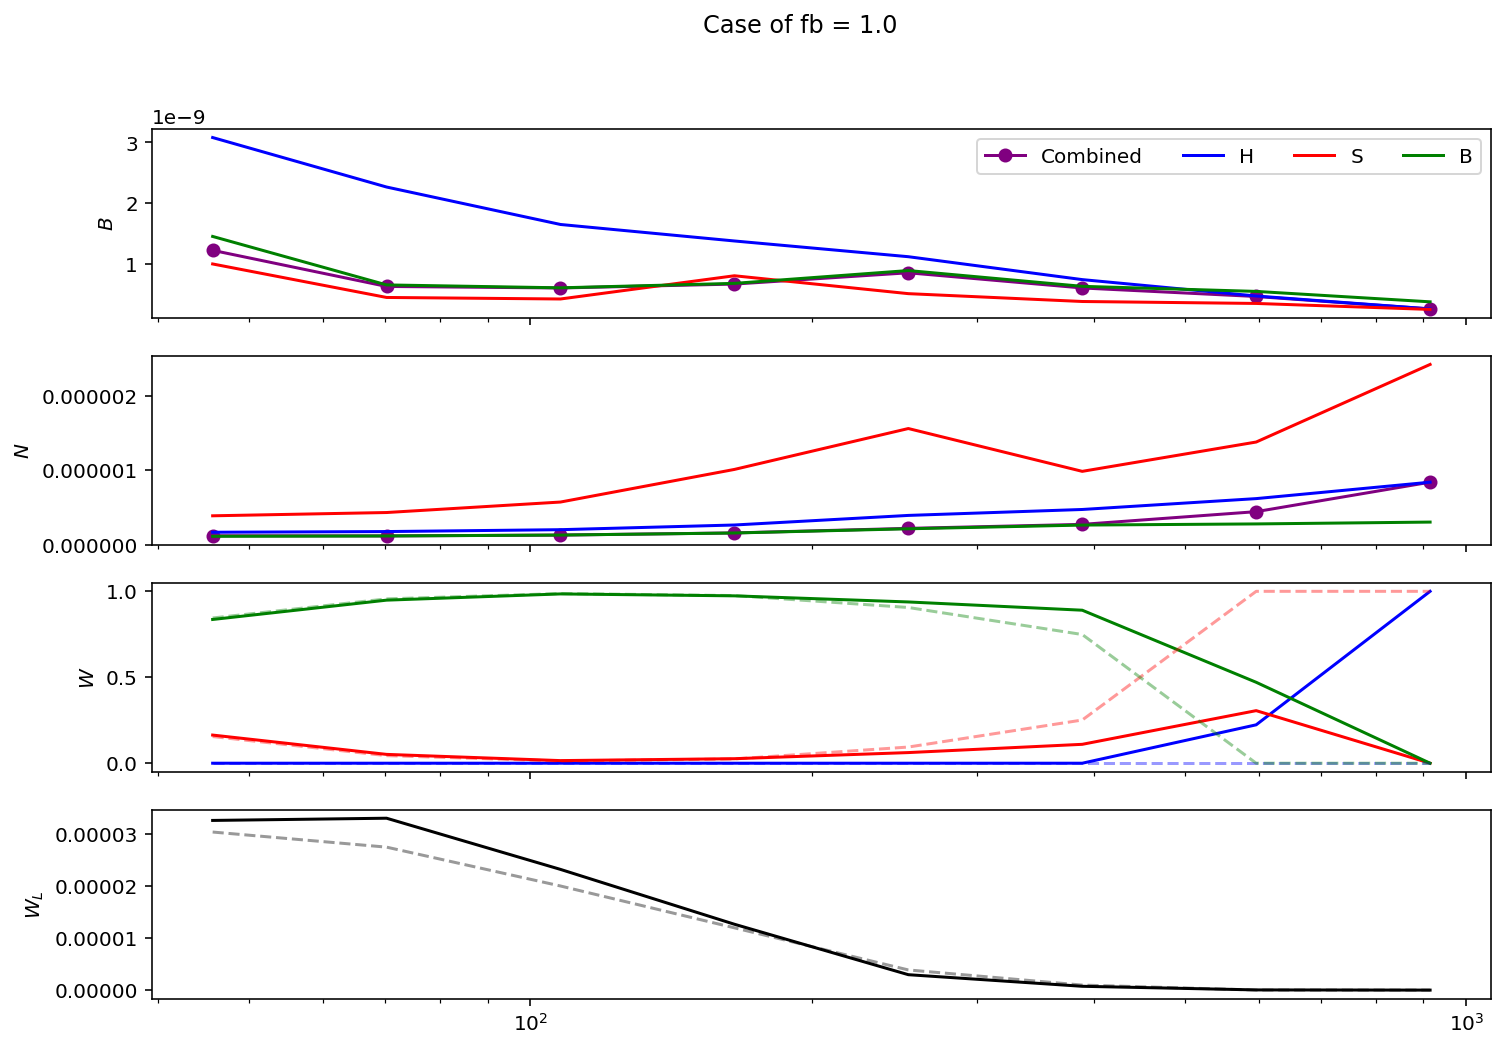

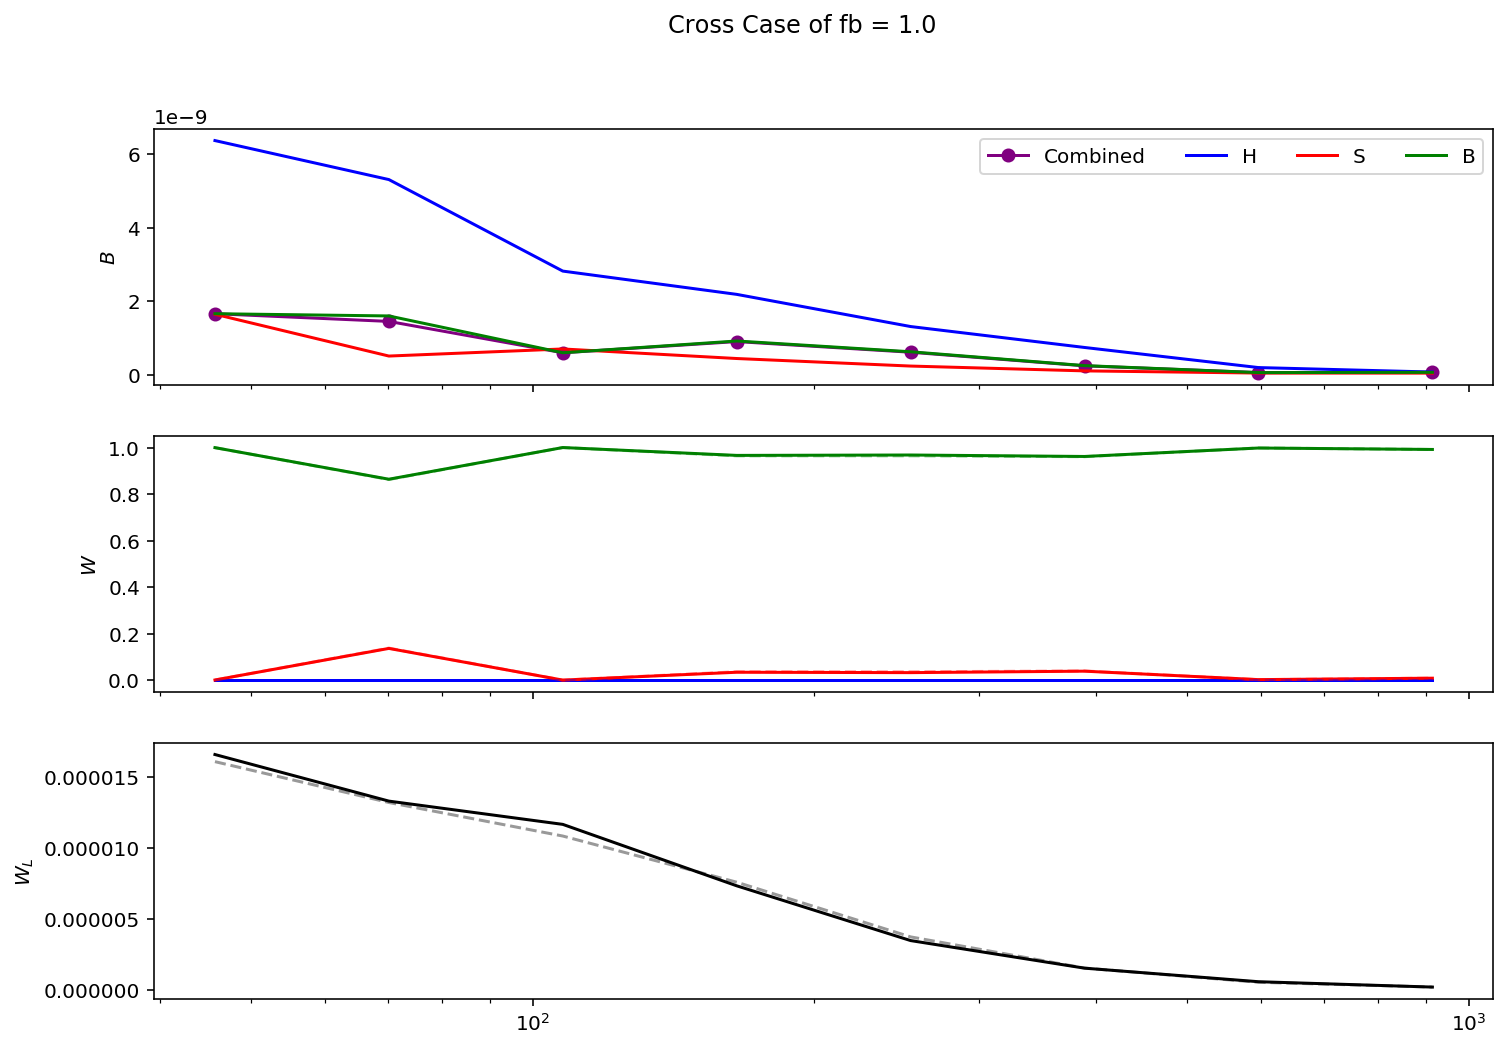

In [298]:
directory = min(autos, key = autos.get)
all_maxes = [directory]
plot_fixed(fb, all_maxes)

**Simple check**

In [163]:
lmax = 3500

In [164]:
fbs = [0., 1., 5., 10., 100.]
noisebiasconstr = False


In [173]:
totals_auto = []
totals_cross = []

noises_auto = []
noises_cross = []

biases_auto = []
biases_cross = []

h3500s3500b3500
0.0
Total auto 4.0284533636240335e-05
Total cross 3.622042315447236e-05
Total auto 4.0284533636237625e-05
Total cross 3.6220423154471514e-05


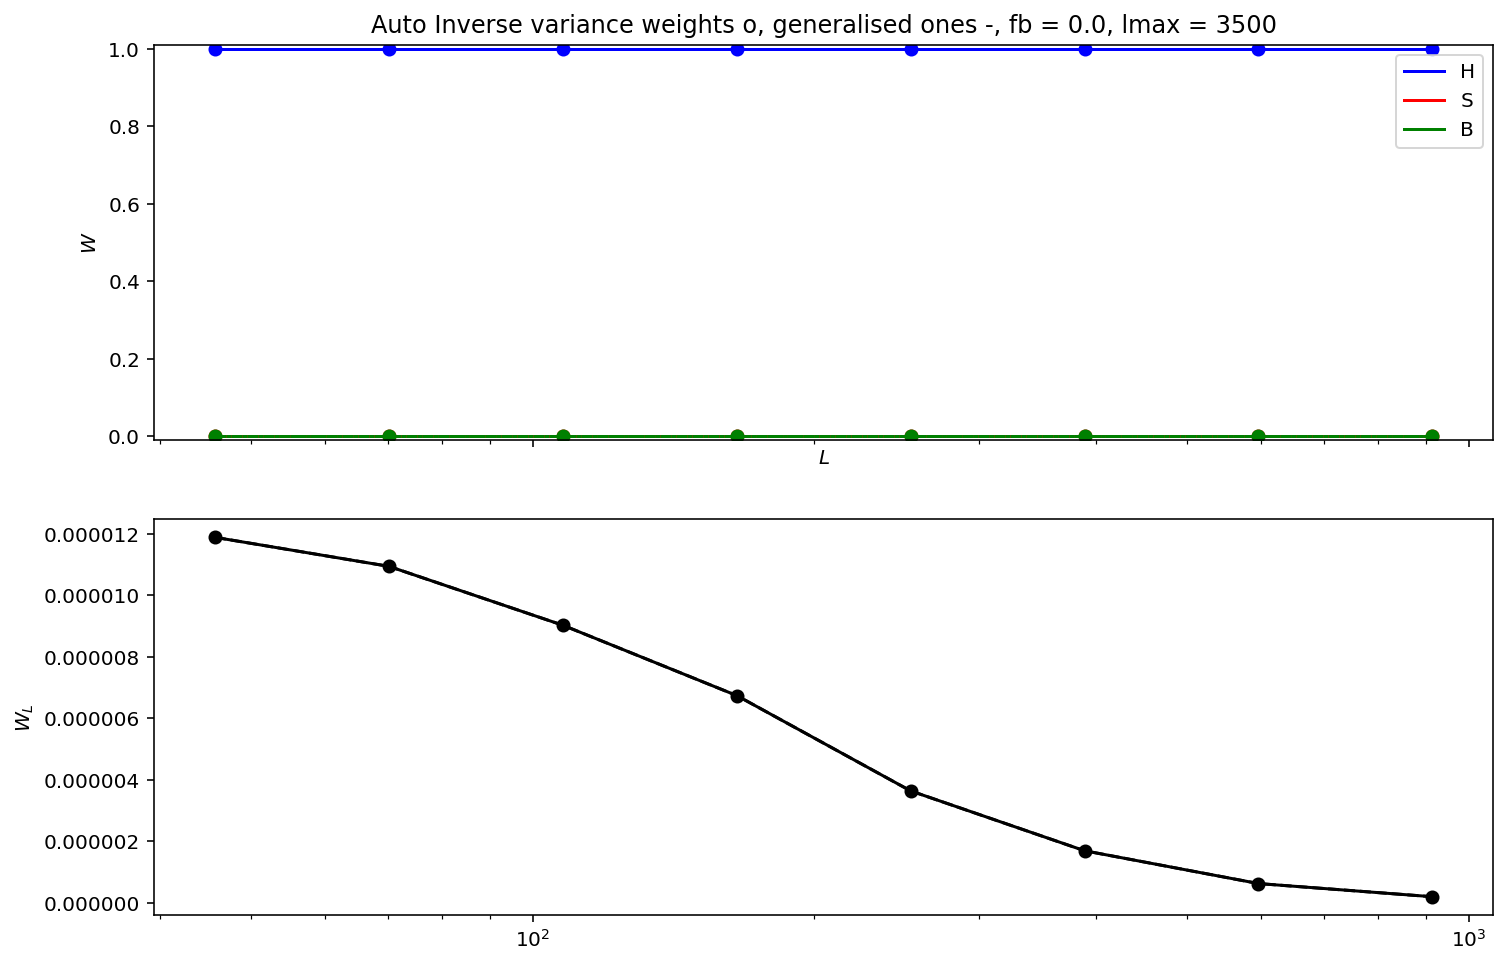

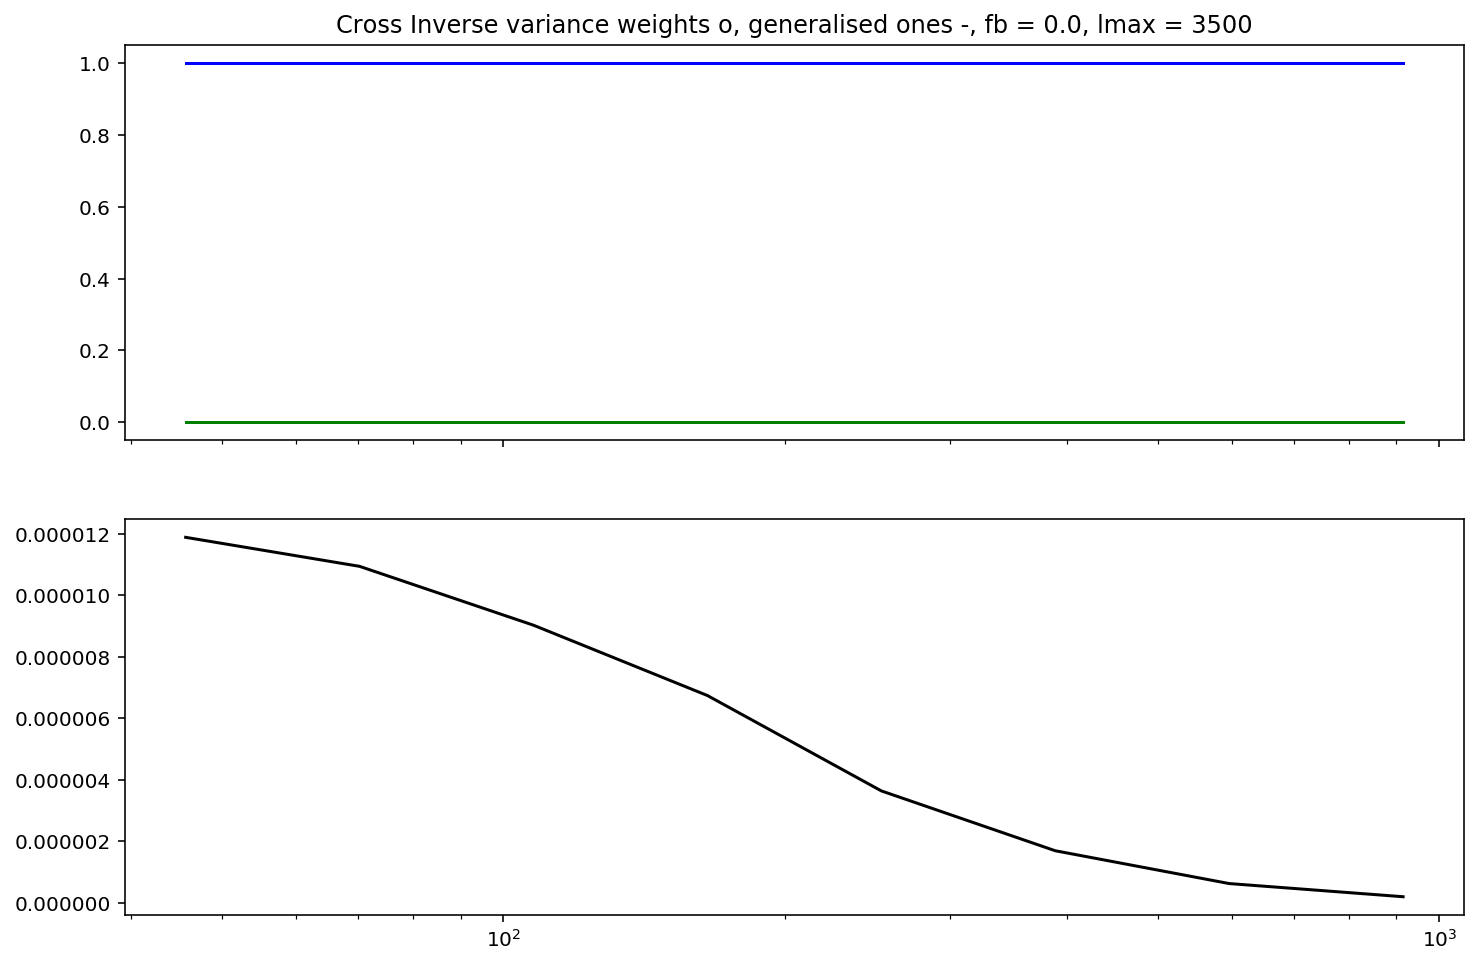

h3500s3500b3500
1.0
Total auto 0.016751710788213324
Total cross 0.013219531761798556
Total auto 0.038638635972422036
Total cross 0.009264855911656749


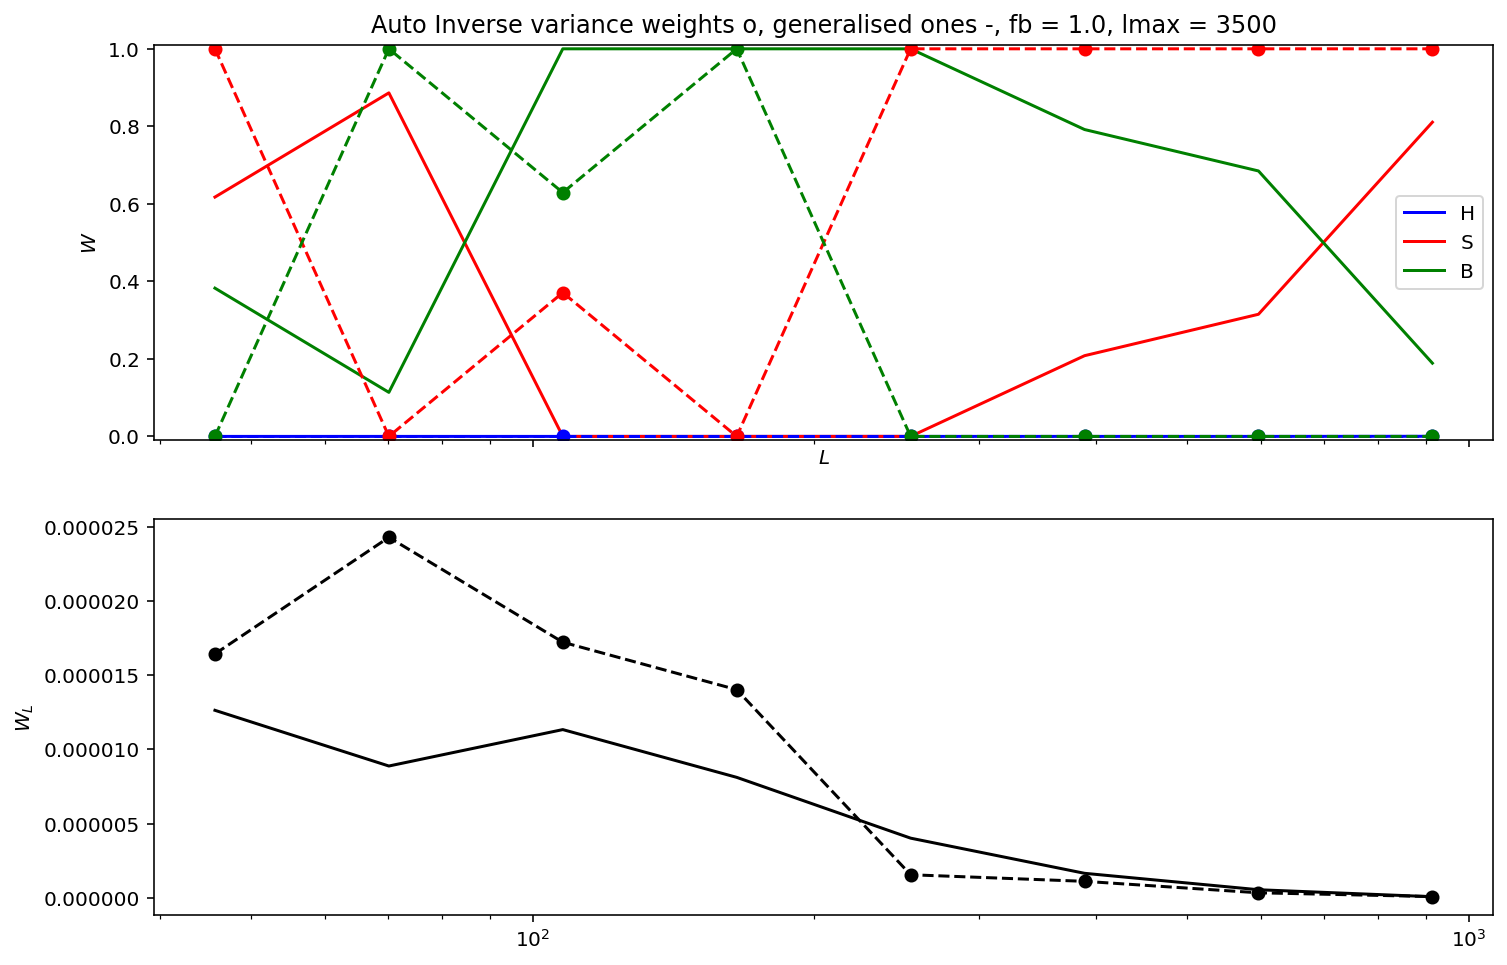

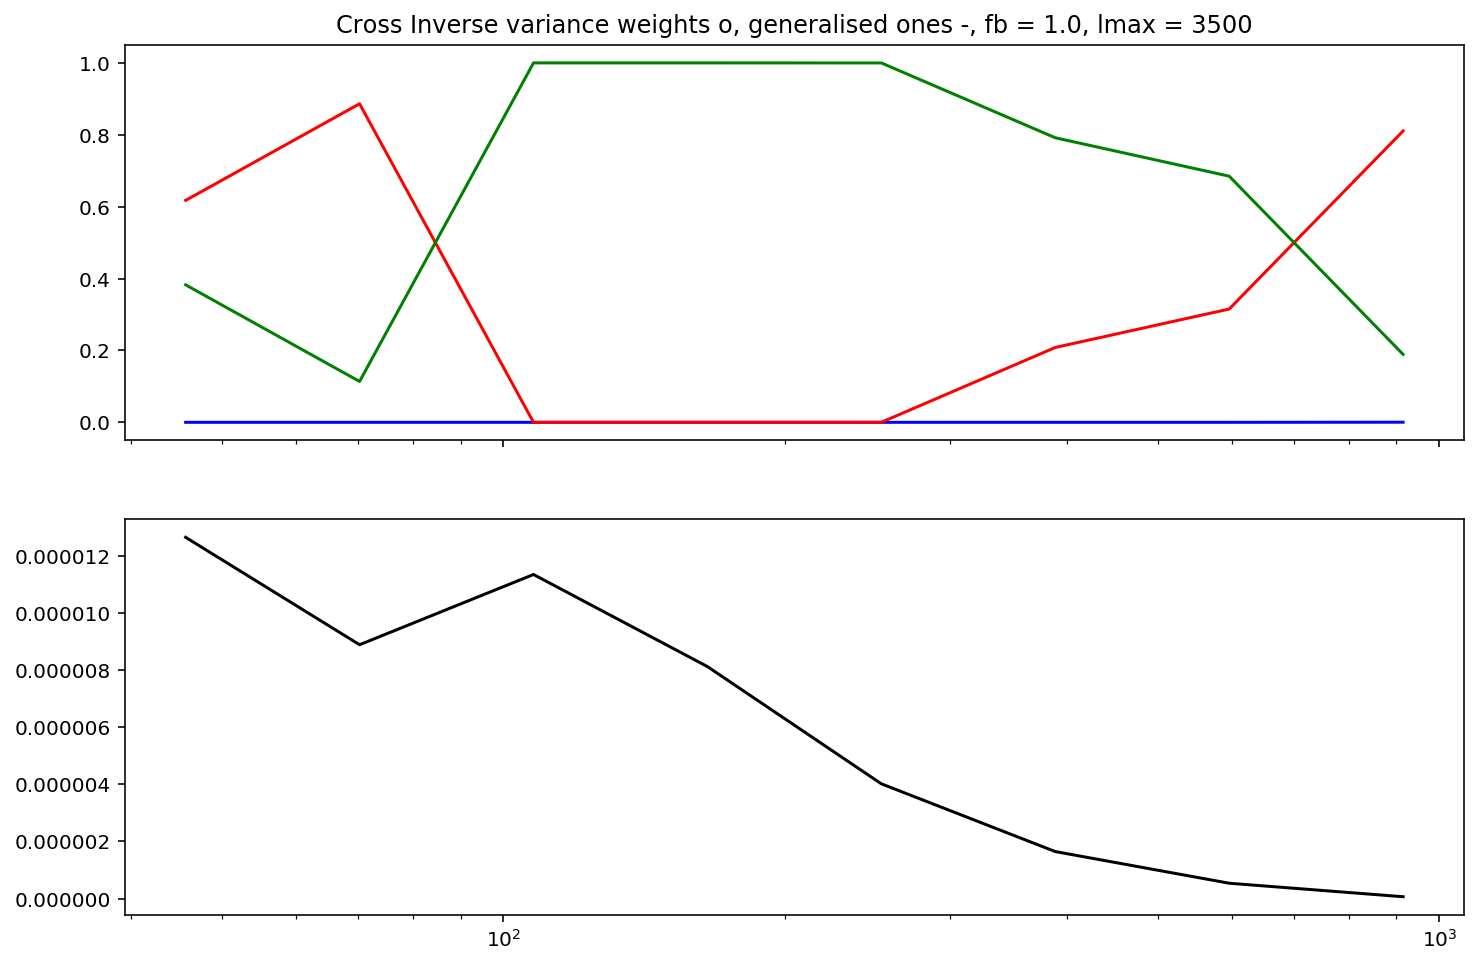

h3500s3500b3500
5.0
Total auto -0.014937550854250187
Total cross 0.002065417195948446
Total auto 0.18322039102824142
Total cross 0.04611235501653909


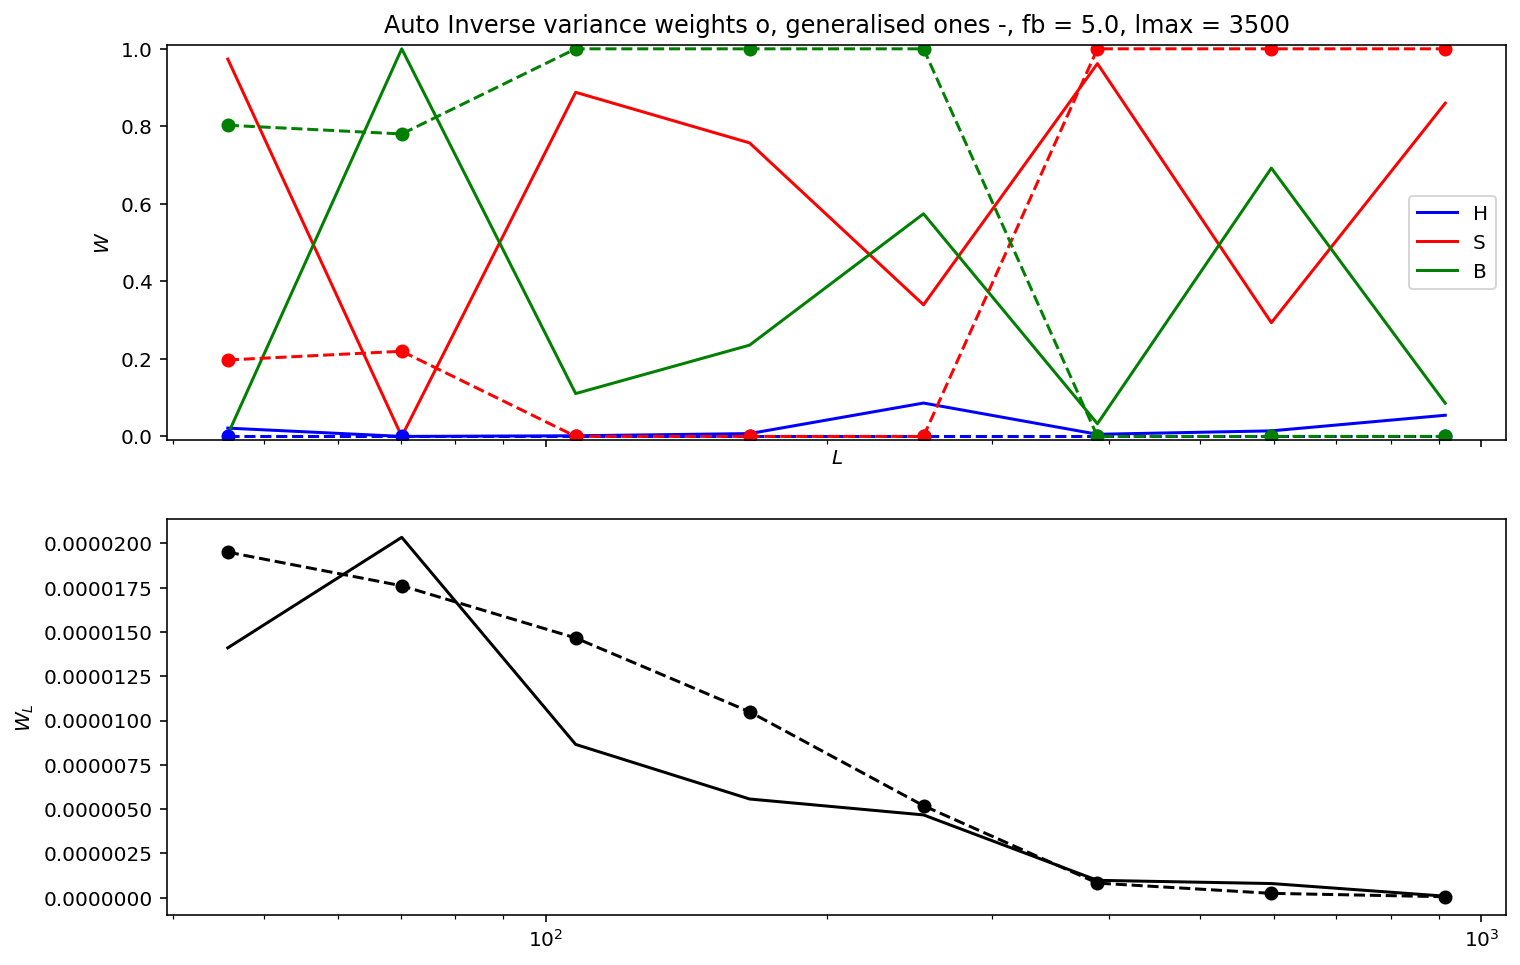

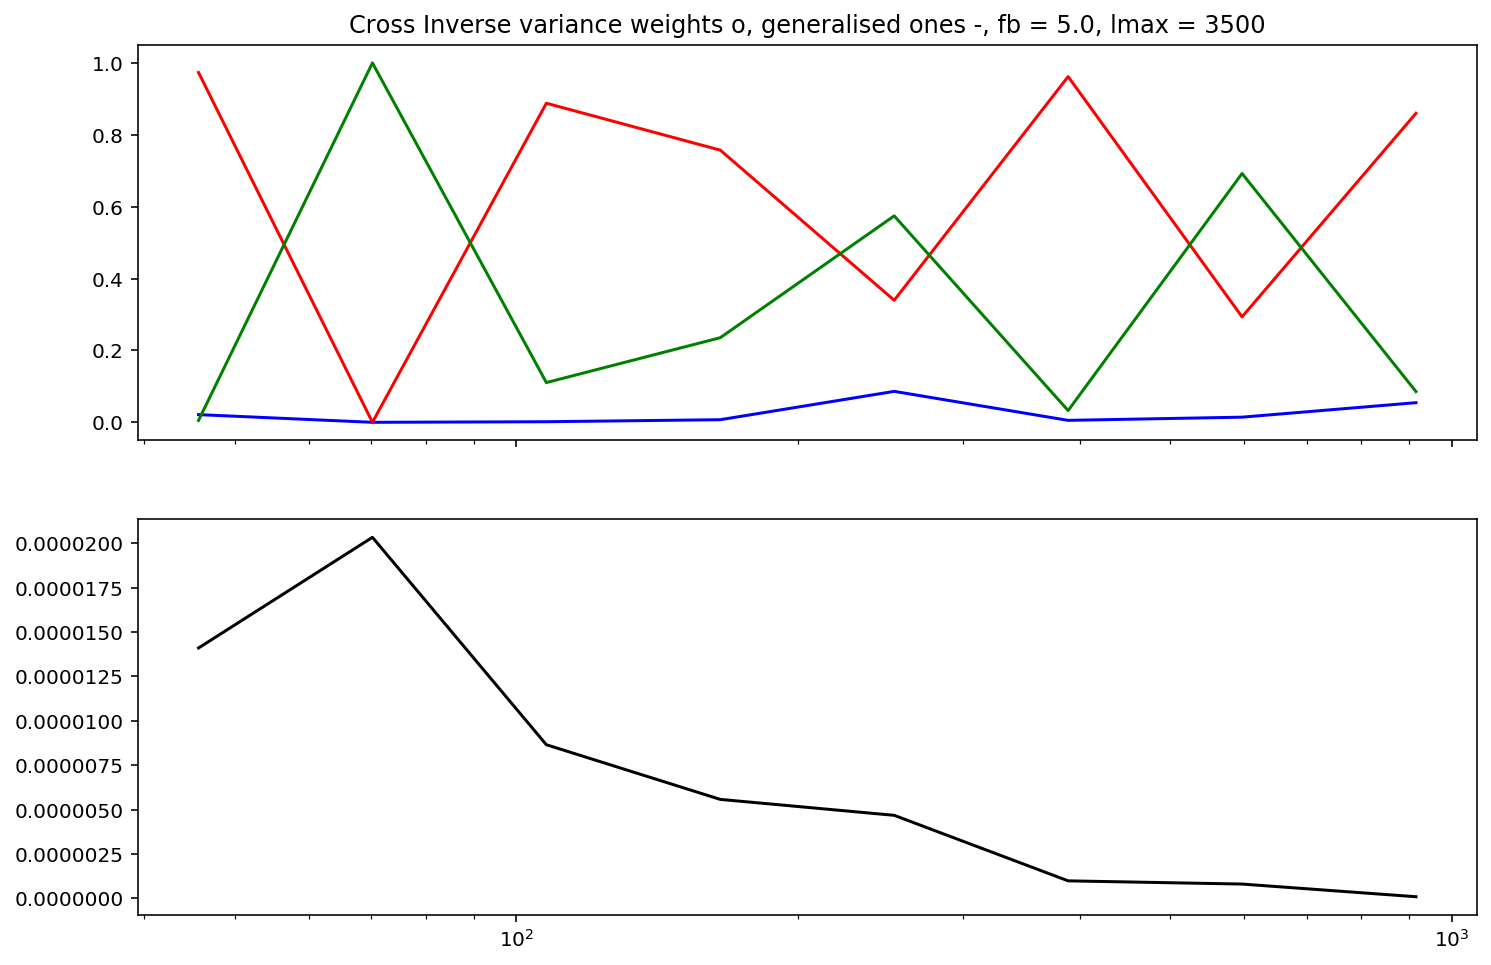

h3500s3500b3500
10.0
Total auto -0.030780507726373526
Total cross -0.0006900720080994776
Total auto 0.3858861846283224
Total cross 0.09207114580221479


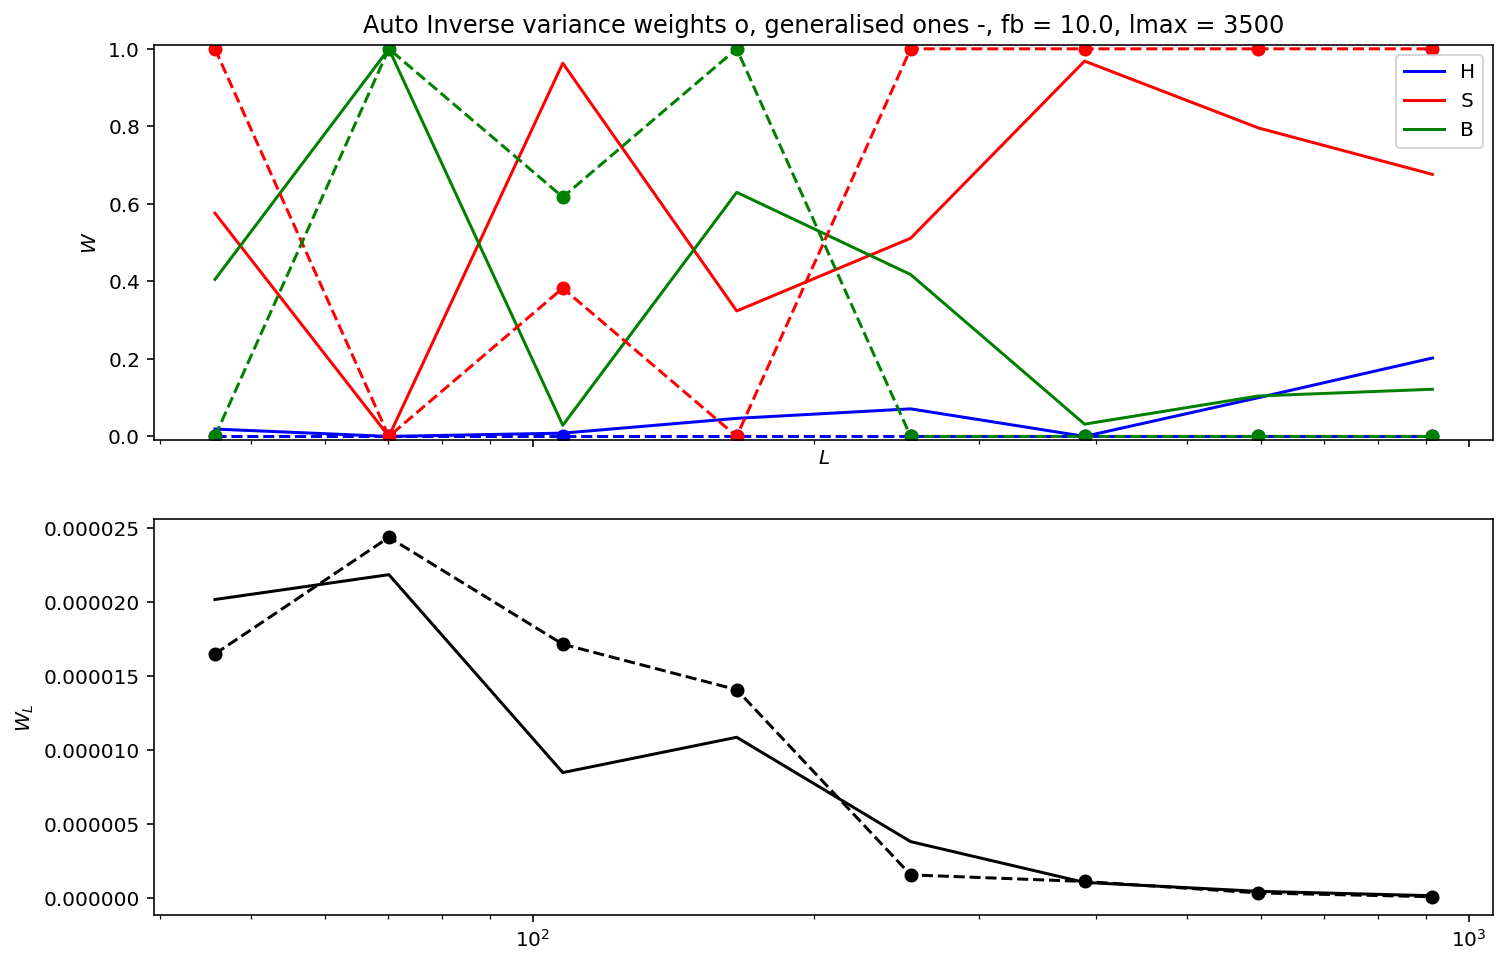

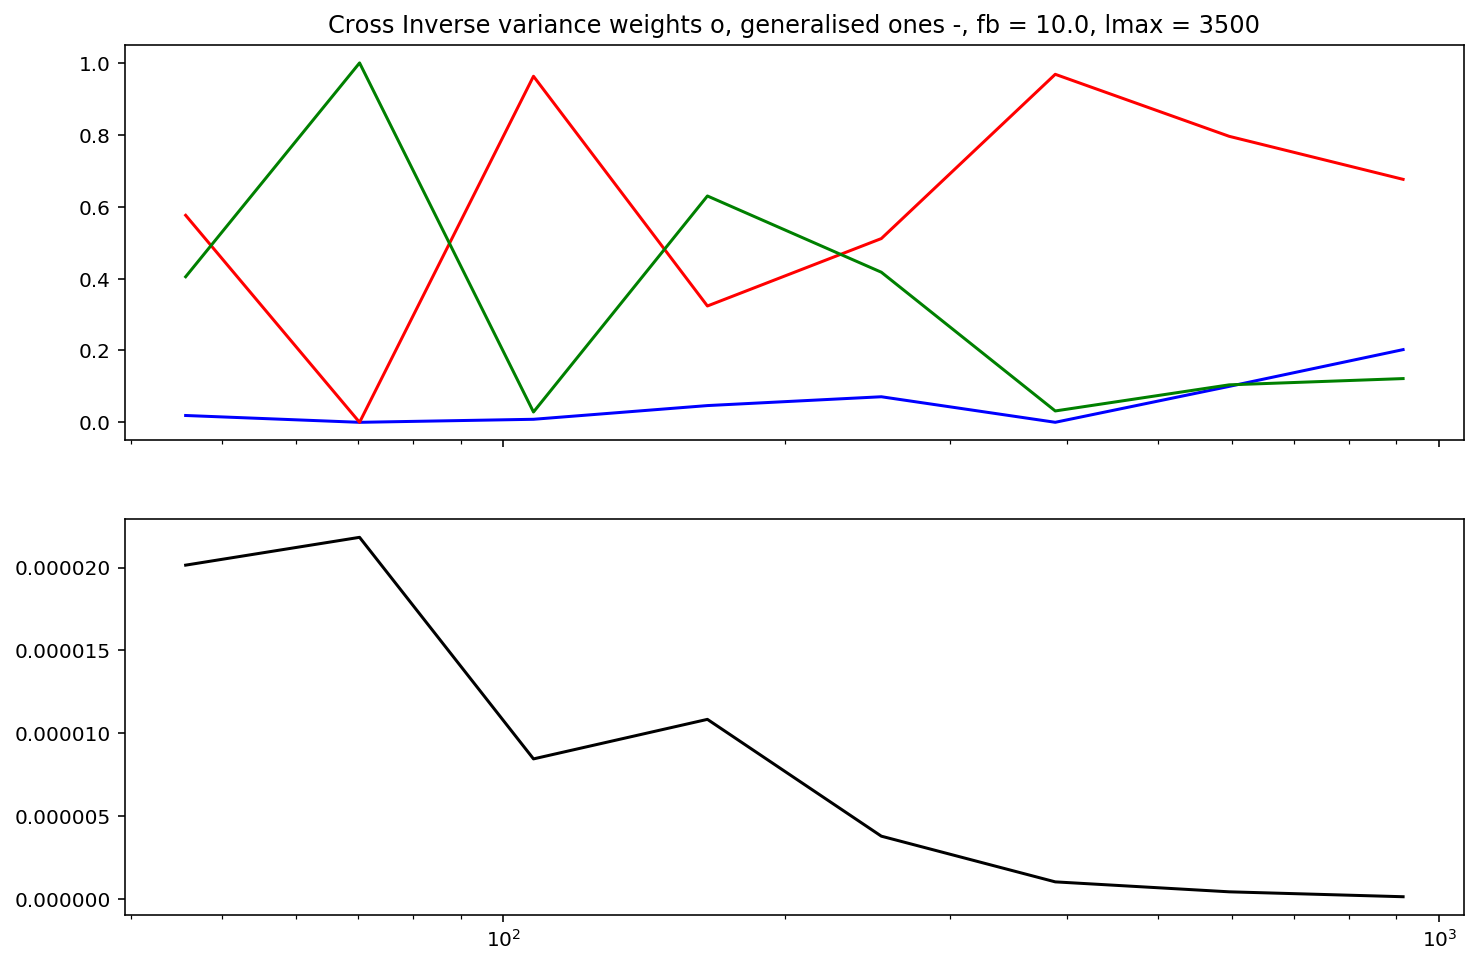

h3500s3500b3500
100.0
Total auto 2.2380571975896824
Total cross 1.8872032915305776
Total auto 3.6630488313781764
Total cross 0.9211900845805014


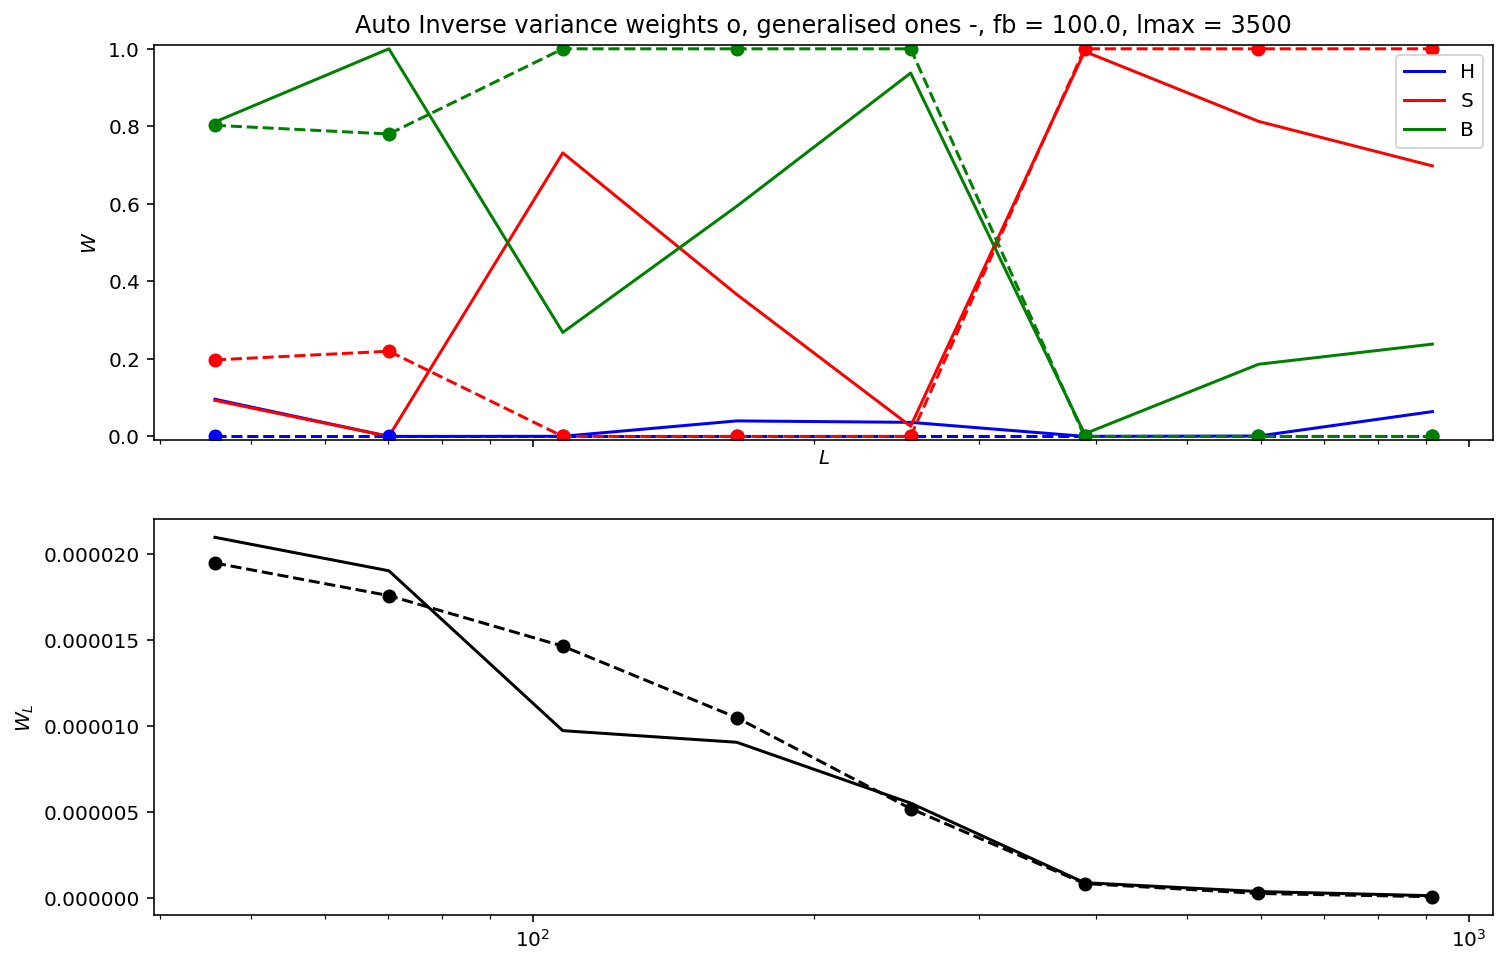

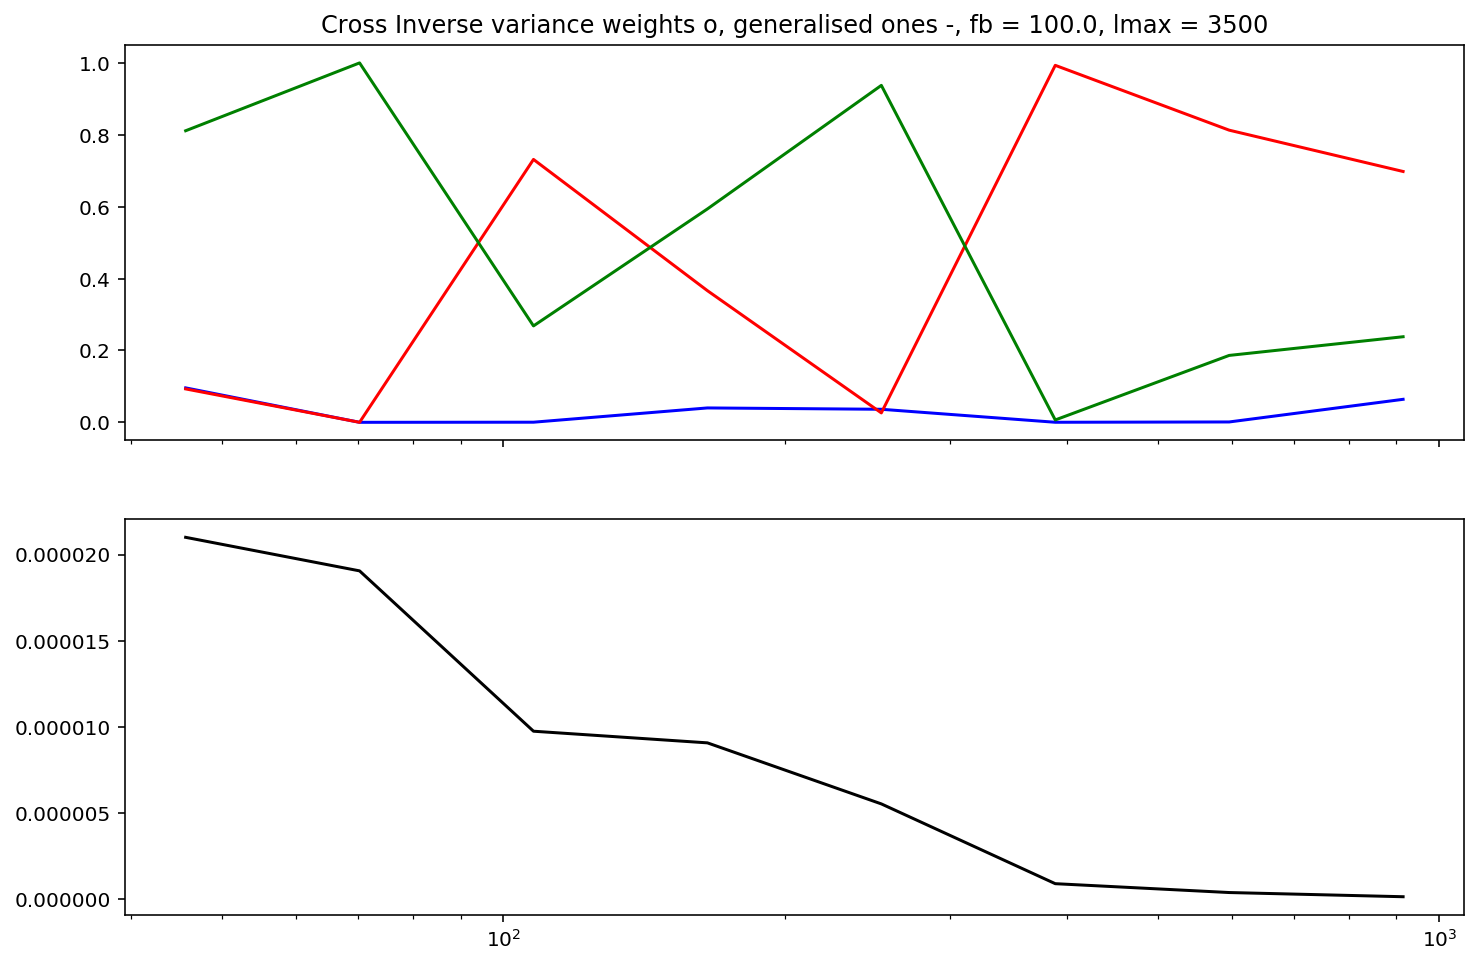

In [174]:
for fb in fbs:
    fig, ax = plt.subplots(nrows = 2, sharex = True)
    ax[0].set_title(f'Auto Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    fig2, ax2 = plt.subplots(nrows = 2, sharex = True)

    ax2[0].set_title(f'Cross Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    for fgnamefile in [fgnamefiles[0]]:
        lmax_directory = f'h{lmax}s{lmax}b{lmax}'
        
        print(lmax_directory)

        invvariance = False


        print(fb)
        
        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auto, cross = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auton, crossn = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        autob, crossb = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        totals_auto += [auto]
        totals_cross += [cross]
        
        noises_auto += [auton]
        noises_cross += [crossn]
        
        biases_auto += [autob]
        biases_cross += [crossb]
        
        
        

        
        ax[0].plot(ells, w1, color = 'blue', label = 'H')
        ax[0].plot(ells, w2, color = 'red', label = 'S')
        ax[0].plot(ells, w3, color = 'green', label = 'B')

        ax[1].plot(ells, wl, color = 'black')
        
        ax2[0].plot(ells, w1, color = 'blue', label = 'H')
        ax2[0].plot(ells, w2, color = 'red', label = 'S')
        ax2[0].plot(ells, w3, color = 'green', label = 'B')

        ax2[1].plot(ells, wl, color = 'black')

        invvariance = True

        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)

        ax[0].plot(ells, w1, color = 'blue', ls = '--', marker = 'o')
        ax[0].plot(ells, w2, color = 'red', ls = '--', marker = 'o')
        ax[0].plot(ells, w3, color = 'green', ls = '--', marker = 'o')

        ax[1].plot(ells, wl, color = 'black', ls = '--', marker = 'o')




    ax[0].set_ylabel('$W$')
    ax[1].set_ylabel('$W_L$')
    ax[0].set_xlabel('$L$')
    ax[0].set_yscale('linear')
    ax[0].set_ylim(-0.01, 1.01)
    ax[-1].set_xscale('log')
    
    ax2[-1].set_xscale('log')

    ax[0].legend()
    plt.show()

Text(0, 0.5, 'Total')

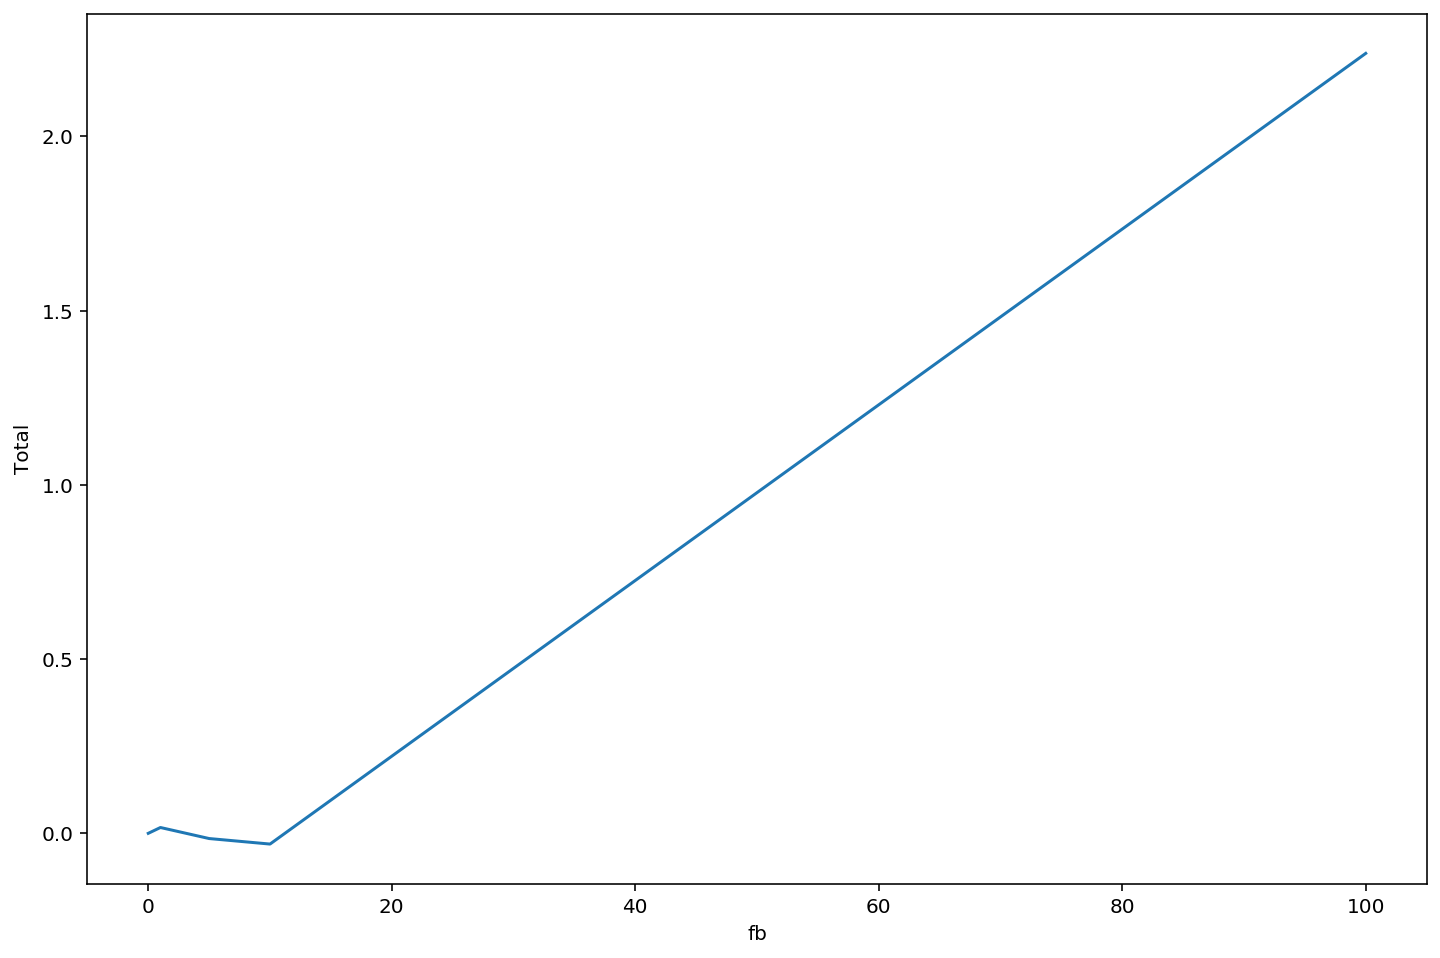

In [170]:
plt.plot(fbs, totals_auto)
plt.xlabel('fb')
plt.ylabel('Total')

Text(0, 0.5, 'Noise')

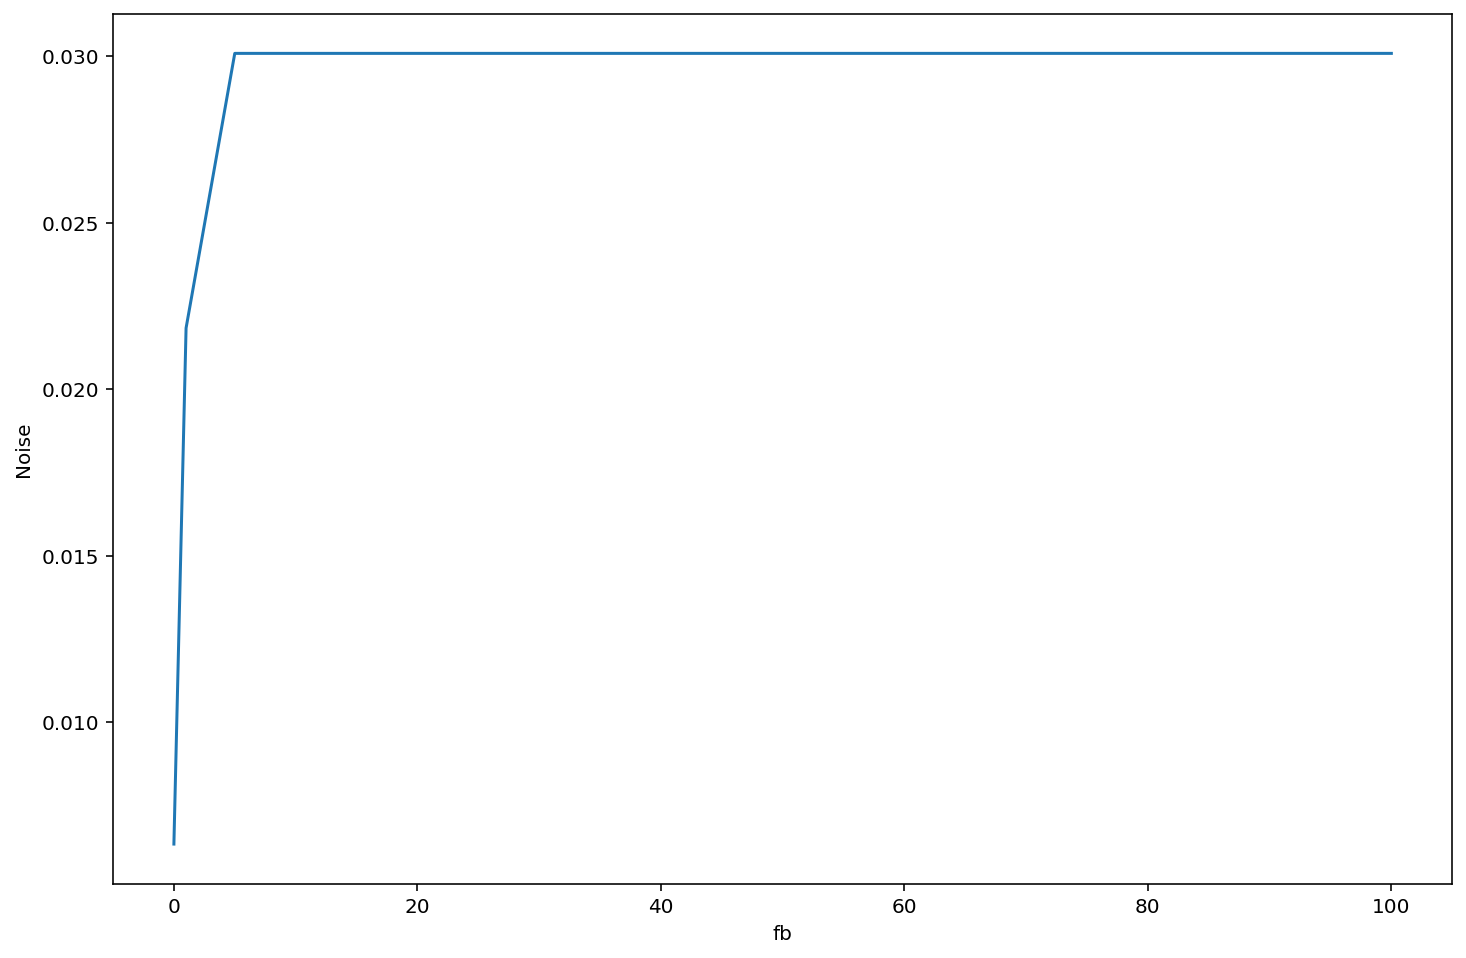

In [175]:
plt.plot(fbs, noises_auto)
plt.xlabel('fb')
plt.ylabel('Noise')

Text(0, 0.5, 'Bias')

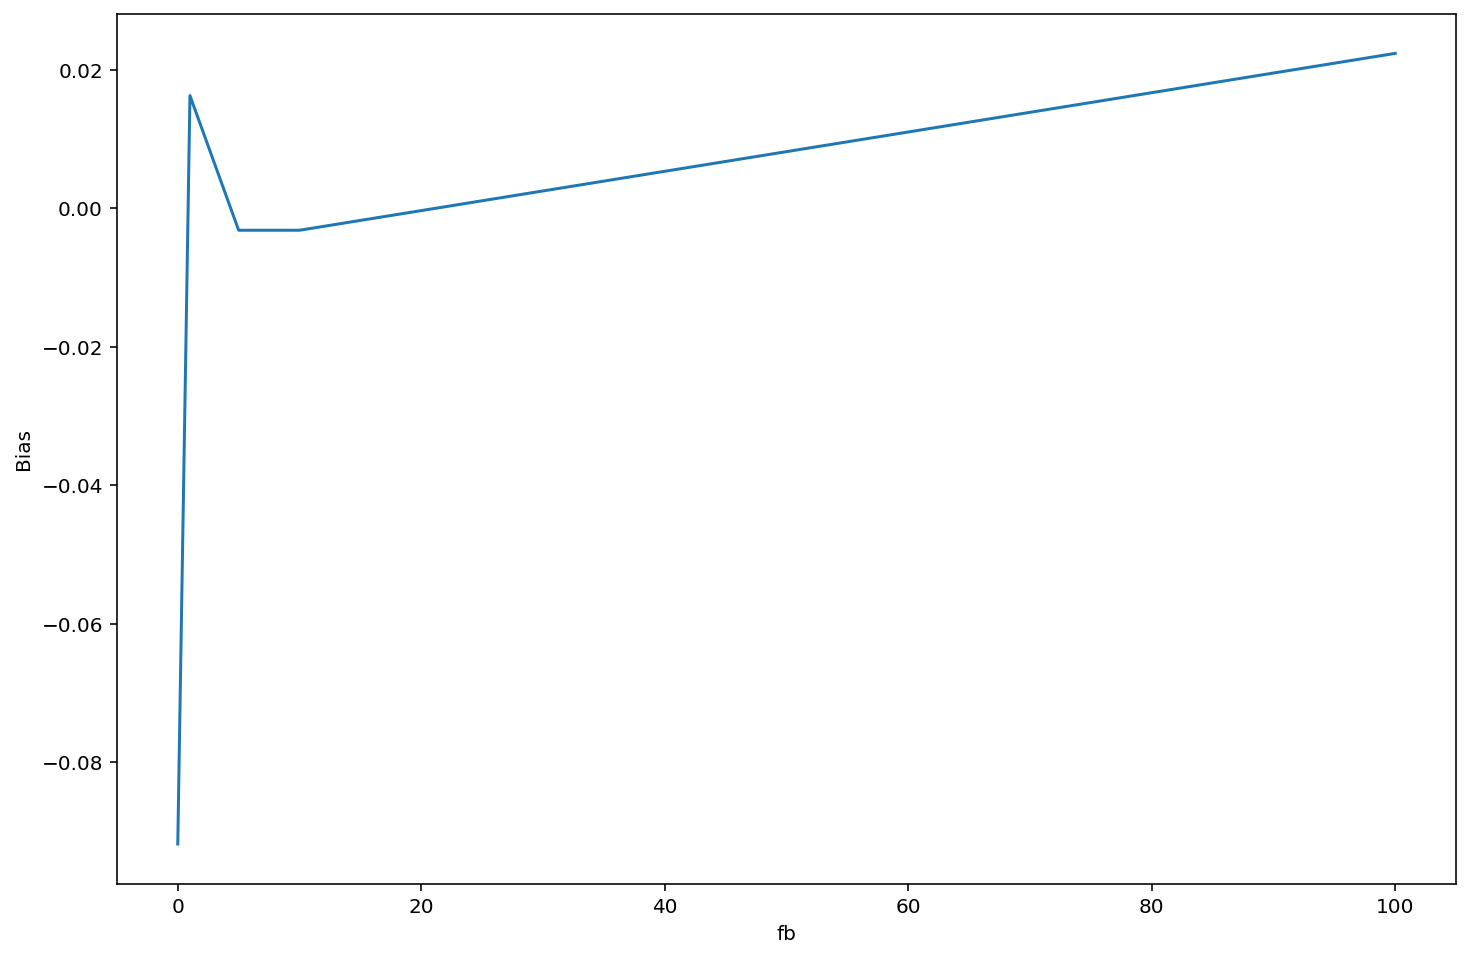

In [177]:
plt.plot(fbs, biases_auto)
plt.xlabel('fb')
plt.ylabel('Bias')

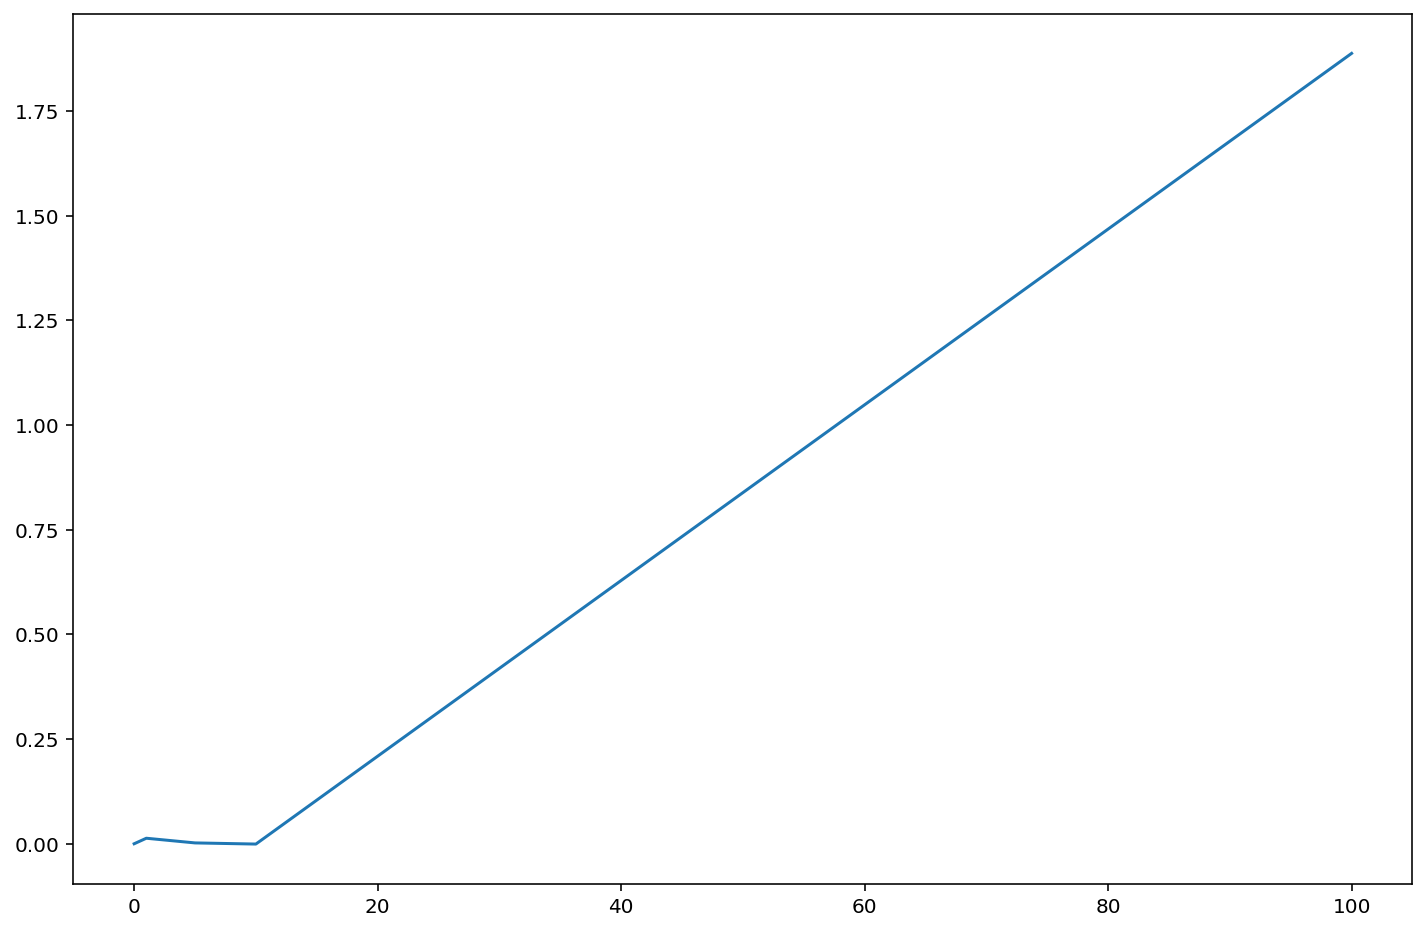

In [171]:
plt.plot(fbs, totals_cross)

In [107]:
min(autos, key = autos.get)

'h4000s4500b4000'

In [110]:
autos['h4000s4500b4000']

-0.007031717557891617

In [111]:
autos['h2000s2000b2000']

-0.0003286623674444945

In [47]:
bh = 3500

In [122]:
results = pathlib.Path('results/')

In [52]:
Res = best.Res(0, 0)

In [101]:
get_directory_lmax = lambda h, s, b: f'h{h}s{s}b{b}'

In [56]:
matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'inversevariance/w_auto_fb_1.0.npy')
ells = matrix[0, :]
w1, w2, w3, w = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'w_cross_fb_1.0.npy')
w1c, w2c, w3c, wc = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

NameError: name 'results' is not defined

In [57]:
plt.plot(ells, w1, color = 'blue', label = 'h')
#plt.plot(ells, w1c, color = 'blue', ls = '--')

plt.plot(ells, w2, color = 'red', label = 's')
#plt.plot(ells, w2c, color = 'red', ls = '--')

plt.plot(ells, w3, color = 'green', label = 'b')
#plt.plot(ells, w3c, color = 'green', ls = '--')

plt.legend()

NameError: name 'ells' is not defined

In [58]:
plt.plot(ells, w, color = 'black')
plt.plot(ells, wc, color = 'black', ls = '--')

NameError: name 'ells' is not defined

In [107]:
import re

re.findall(r'\d+', 'h3000s2000b3000')

['3000', '2000', '3000']

In [108]:
P

PosixPath('output/h4500s4500b4500')

In [115]:
path = pathlib.Path('output')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]
len(all_lmaxes_directories)

128